In [1]:
using Pkg
Pkg.activate("deconvolution"; shared=true)

  likely near /Users/imolk/Library/Julia/packages/IJulia/nBp96/src/kernel.jl:41
  likely near /Users/imolk/Library/Julia/packages/IJulia/nBp96/src/kernel.jl:41


"/Users/imolk/Library/Julia/environments/deconvolution/Project.toml"

$$
\newcommand{\genericdel}[3]{%
      \left#1{#3}\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\poisson}{Poisson}
    \DeclareMathOperator{\dif}{d}
    \newcommand{\od}[2]{\frac{\dif{#1}}{\dif{#2}}}
    \DeclareMathOperator{\Forall}{\forall}
    %
    % linear algebra
    %
    \DeclareMathOperator{\ones}{\mathbf{1}}   
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\trans}{^{\intercal}}
    \DeclareMathOperator{\trace}{trace}
$$

In this notebook, I implement the Efron deconvolution algorithm.

**Next steps:**
- ~~compute the derivative of the PDF using autodiff~~
- ~~compute the derivative of the PDF analytically~~
- ~~maximize the PDF to obtain the MLE given noise-free data~~
- ~~add a noise likelihood and propagate the gradient~~
- ~~maximize the likelihood to obtain the MLE given noisy data~~
- ~~implement regularization?~~
- ~~make it faster somehow?~~

In [2]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/LaTeXStrings/H4HGh.ji for LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f]
└ @ Base loading.jl:1185
┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1185


In [85]:
using Distributions
using Distributions: params
using StatsBase
using ForwardDiff
import Optim
using Optim: TwiceDifferentiable, optimize
using RCall

In [4]:
using BenchmarkTools
using Random

# Implement Exponential Family w/ Splines

In [5]:
m = 31 # discretization resolution, odd numbers are better
# discretized space of noise-free variables:
θvec = collect(range(-3,stop=3,length=m))
p = 5 # number of parameters
Q = convert(Matrix{Float64}, R"splines::ns($θvec, $p)")
size(Q)

(31, 5)

**Plot spline basis**

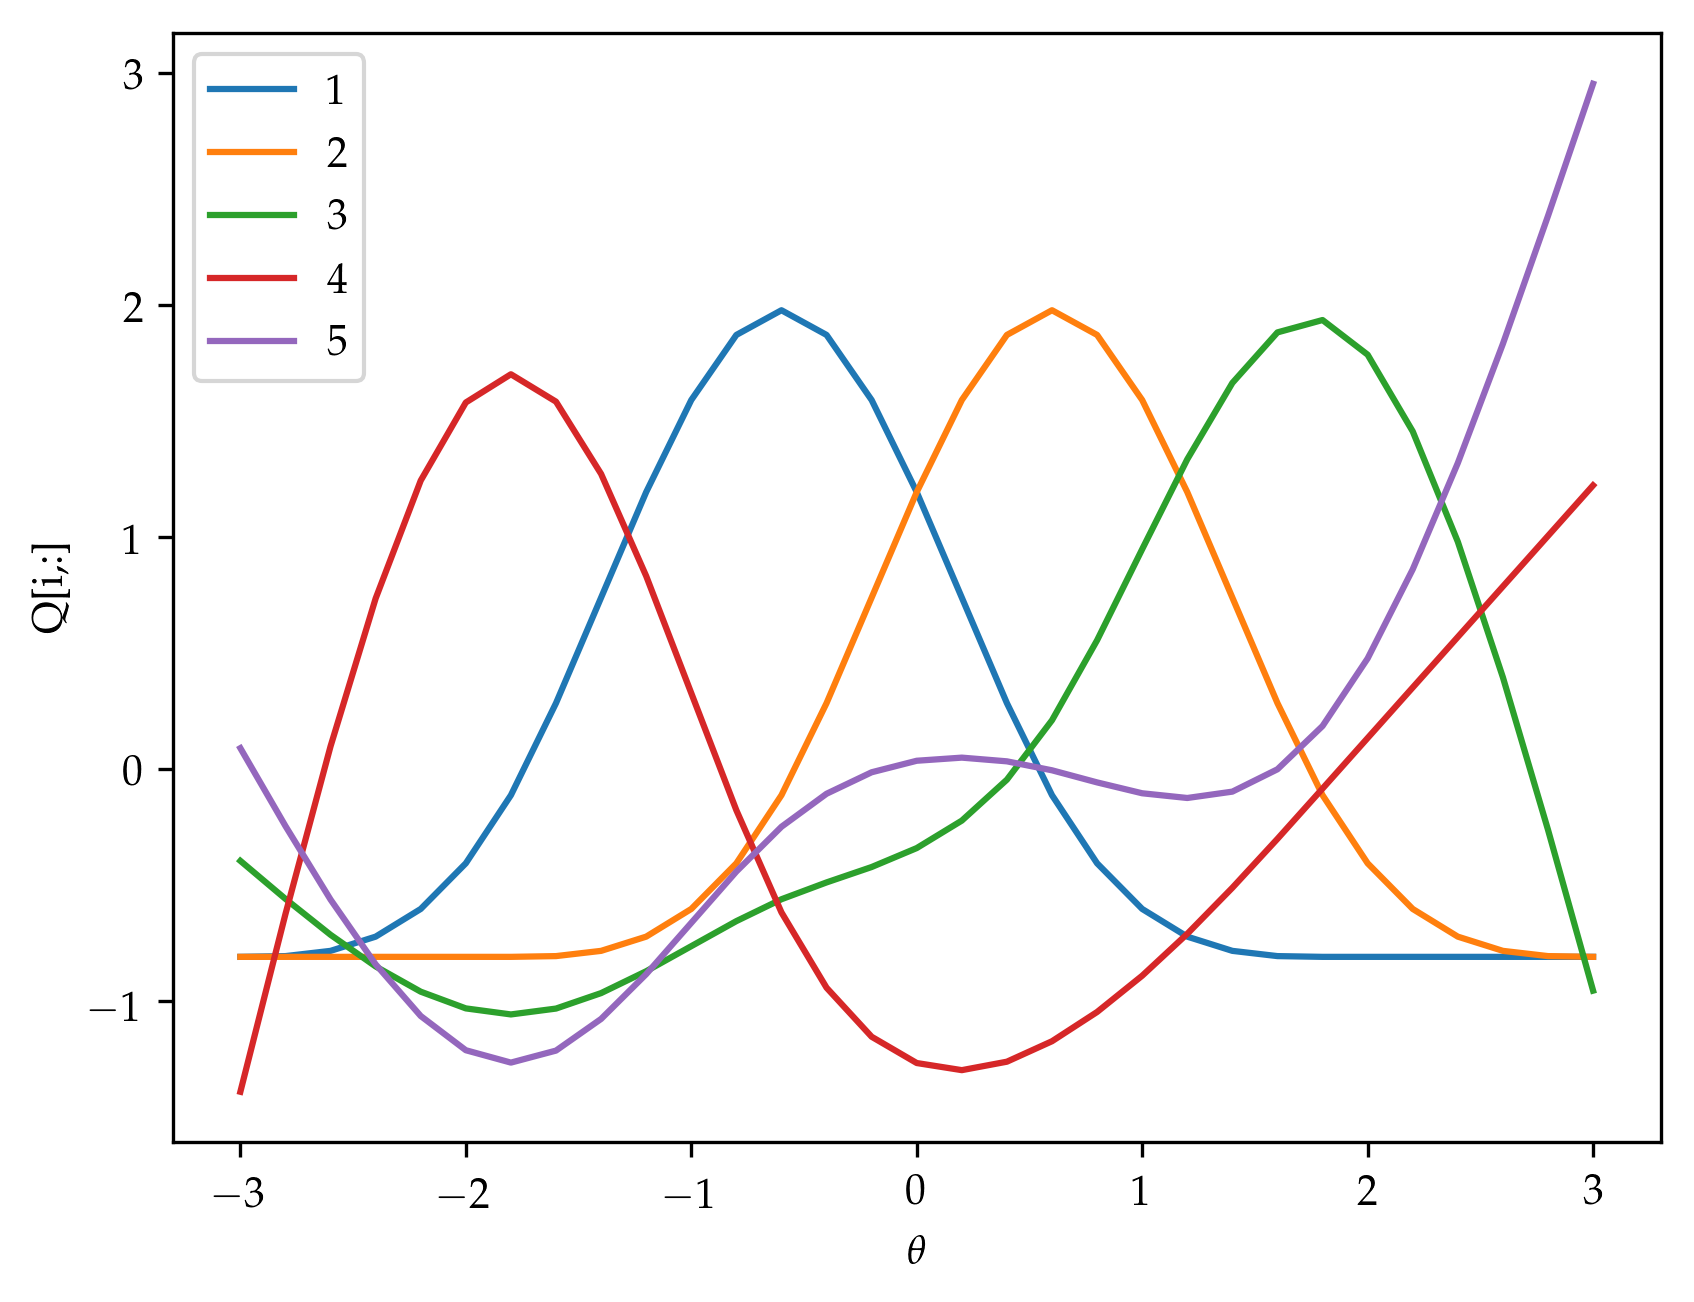

In [6]:
for param in 1:p
    # standardize
    Q[:, param] .-= mean(Q[:, param])
    Q[:, param] ./= std(Q[:, param])
    plt.plot(θvec, Q[:, param], label=string(param))
end
plt.legend(loc="best")
plt.xlabel(L"\theta")
plt.ylabel("Q[i,:]")
;

**Generate a random distribution**

We create a random distribution by using random numbers for the parameter vector $\alpha$.

In [7]:
α = randn(p)

expQα = exp.(Q*α)
φ_α = log(sum(expQα))
g_α = exp.(Q*α .- φ_α) # normalized
;

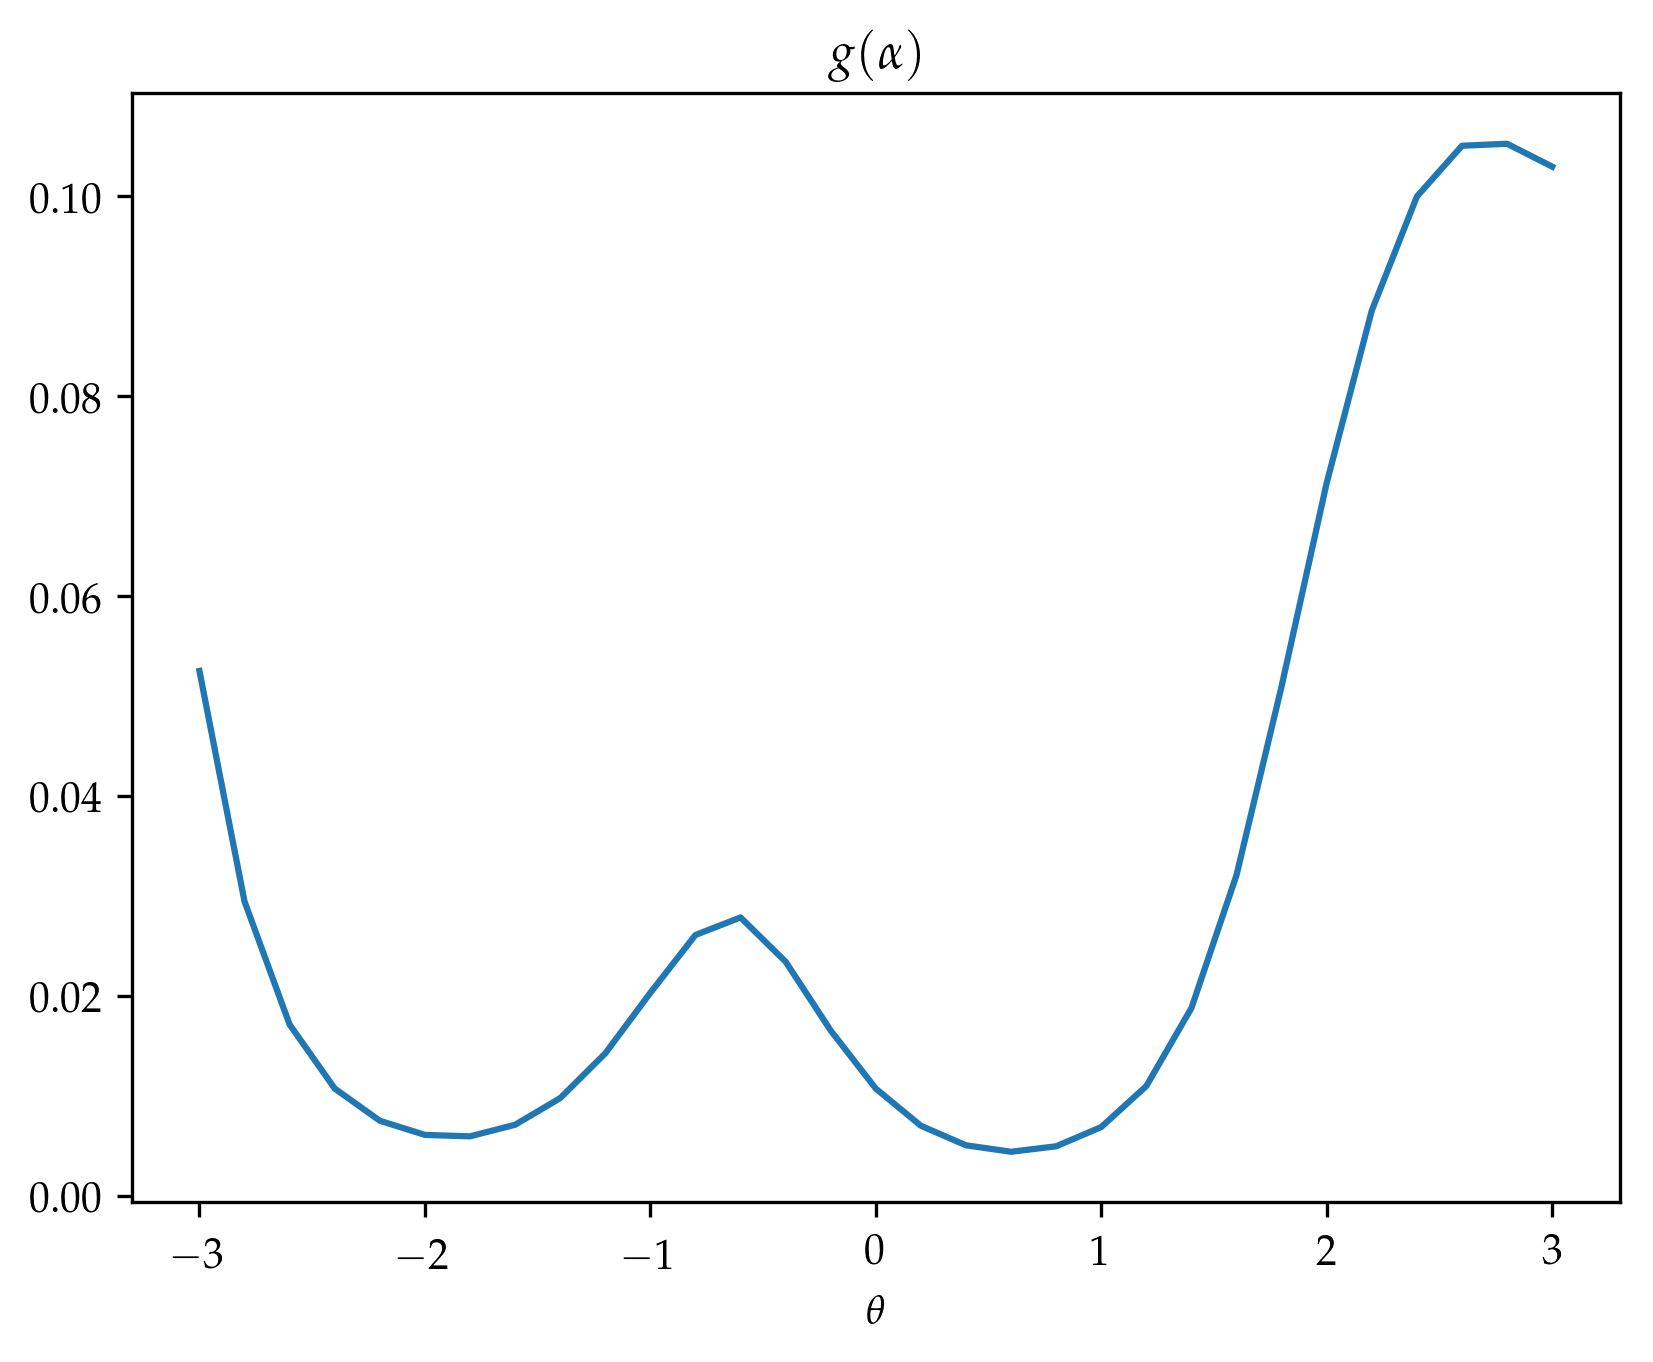

In [8]:
plt.plot(θvec, g_α)
plt.title(L"g(\alpha)")
plt.xlabel(L"\theta")
;

**Now let's do it a few times**

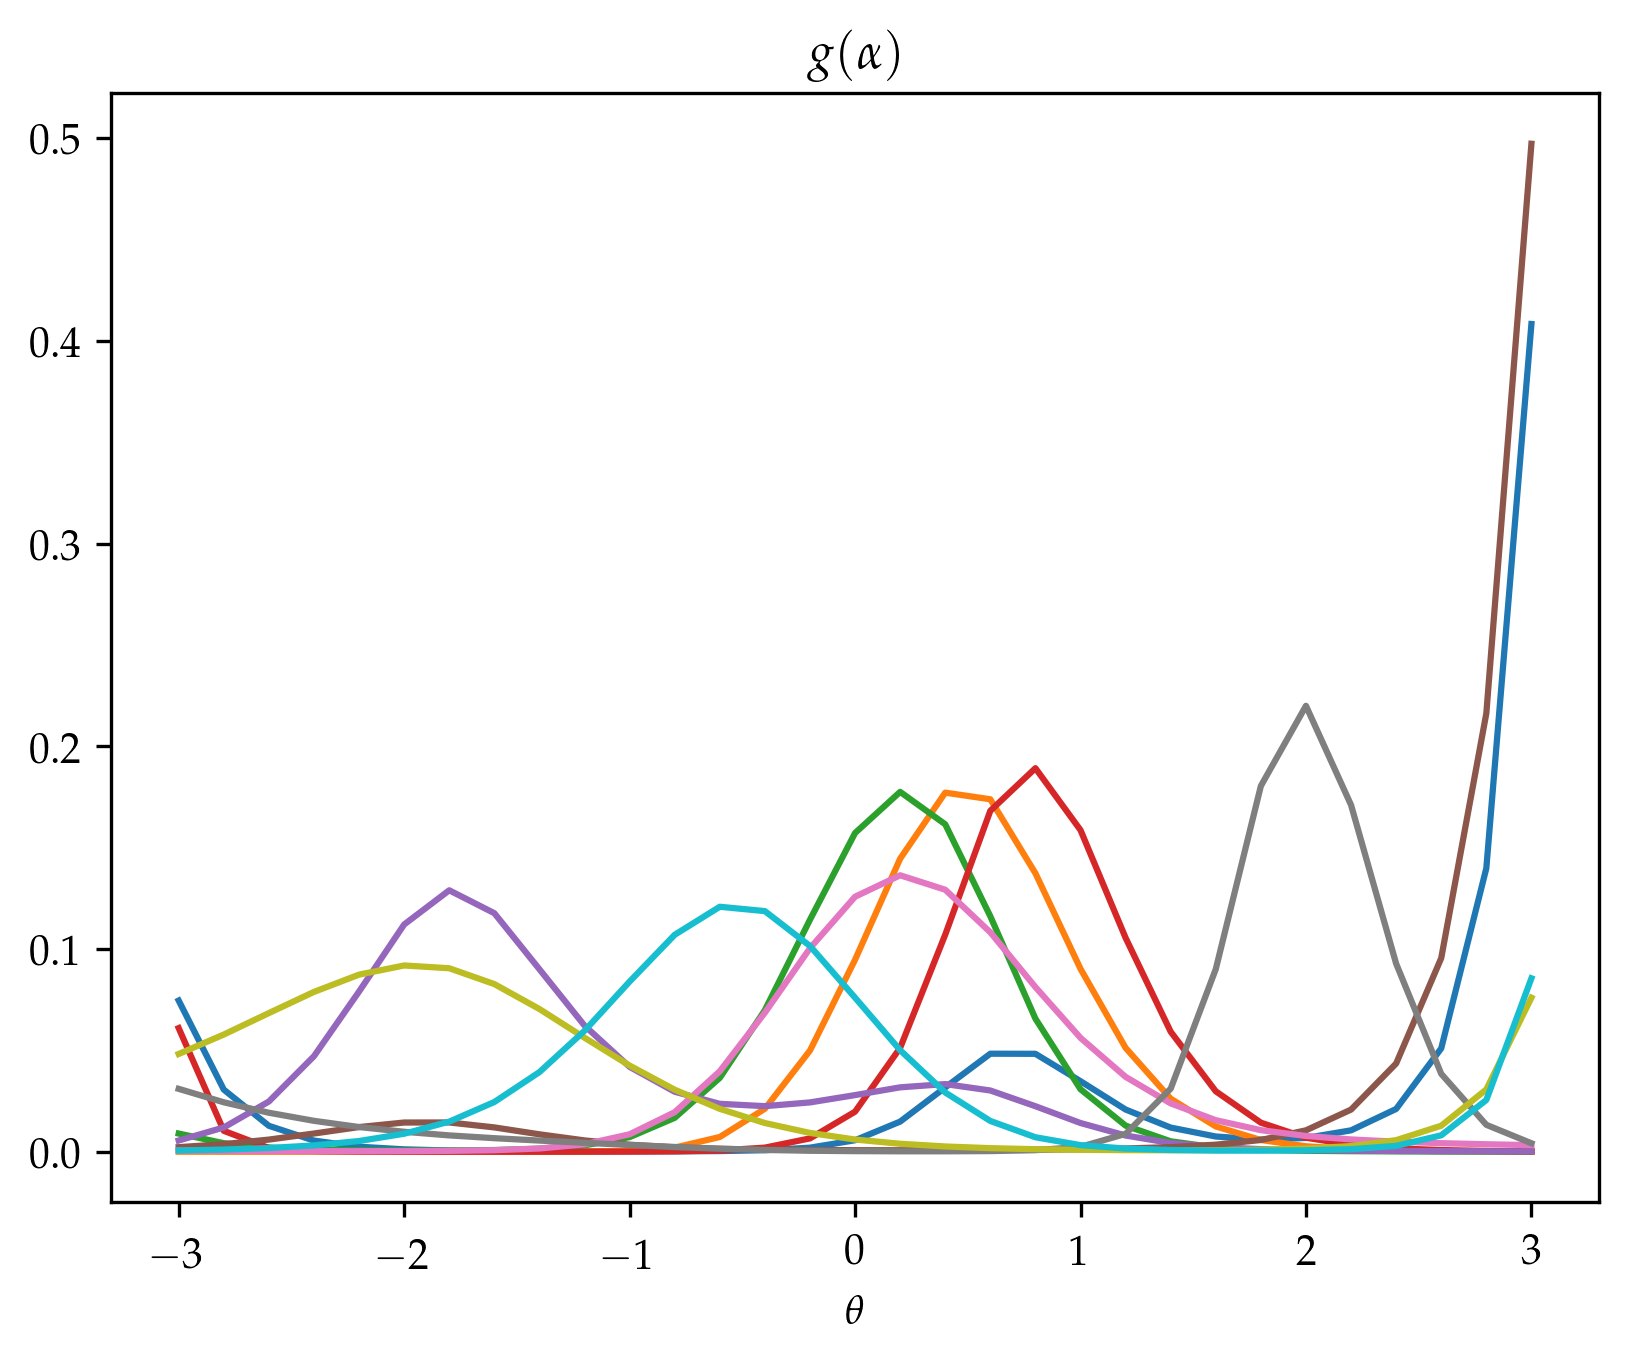

In [9]:
for _ in 1:10
    α = randn(p)
    expQα = exp.(Q*α)
    φ_α = log(sum(expQα))
    g_α = exp.(Q*α .- φ_α) # normalized
    plt.plot(θvec, g_α)
end
plt.title(L"g(\alpha)")
plt.xlabel(L"\theta")
;

# Module

I put this family of distributions into a module for easy re-use.
The code is cleaned-up a bit, but there's otherwise nothing new here.

In [101]:
module ExpoFamSpline
    import Distributions: params, partype,
                          logpdf, pdf,
                          UnivariateDistribution,
                          DiscreteUnivariateDistribution, 
                          insupport
    using LinearAlgebra: diagm, norm
    using RCall
    function spline_basis(domain, p)
        R_spline = R"splines::ns($domain, $p)"
        Q = convert(Matrix{Float64}, R_spline)
        return Q
    end
    
    struct ExpoSpline{T<:Real} <: DiscreteUnivariateDistribution
        domain::Vector{Float64}
        Qbasis::Matrix{Float64} # basis matrix
        αcoef::Vector{T} # α
        Qα::Vector{T}
        φ_α::T # normalization constant
    end
    function ExpoSpline(domain, Qbasis::Matrix{Float64}, αcoef::Vector{T}) where {T <: Real}
        Qα = Qbasis * αcoef
        φ_α = log_sum_exp(Qα) # equation (10)
        return ExpoSpline(domain, Qbasis, αcoef, Qα, φ_α)
    end
    function ExpoSpline(domain, αcoef::Vector{T}) where {T <: Real}
        p = length(αcoef)
        Q = spline_basis(domain, p)
        return ExpoSpline(domain, Q, αcoef)
    end 
    function update_coefs!(d::ExpoSpline{T}, α::Vector{T}) where {T <: Real}
        d.αcoef = α
        LinAlg.A_mul_B!(d.Qα, d.Qbasis, α)
        d.φ_α = log_sum_exp(d.Qα)
        return d
    end
    
    params(d::ExpoSpline) = (d.αcoef, )
    coefs(d::ExpoSpline) = d.αcoef
    partype(d::ExpoSpline{T}) where {T<:Real} = T
    
    function log_sum_exp(x)
        # https://en.wikipedia.org/wiki/LogSumExp
        max_x = maximum(x)
        log_sum_exp_x = max_x + log(sum(xi -> exp(xi-max_x), x))
        return log_sum_exp_x
    end
    logpdf(d::ExpoSpline{T}) where T = d.Qα .- d.φ_α             # equation (9)
    pdf(d::ExpoSpline{T}) where T = exp.(logpdf(d))
    logpdf(d::ExpoSpline{T}, j::Int) where {T} = d.Qα[j] - d.φ_α # equation (9)
    function logpdf(d::ExpoSpline{T}, x::Real) where {T}
        j = argmin(abs.(d.domain .- x)) # not the fastest way to do this
        return logpdf(d, j)
    end
    function pdf(d::ExpoSpline{T}, x::Real) where {T}
        return exp(logpdf(d, x))
    end
    function get_logPi(domain::Vector{Float64}, noise::UnivariateDistribution, X_i::Float64)
        # unnormalized
        return logpdf.(noise, X_i.-domain)
    end
    function get_Pi(domain::Vector{Float64}, noise::UnivariateDistribution, X_i::Float64)
        # unnormalized
        return pdf.(noise, X_i.-domain)
    end
    get_logPi(d::ExpoSpline, noise, X_i) = get_logPi(d.domain, noise, X_i)
    get_Pi(d::ExpoSpline, noise, X_i) = get_Pi(d.domain, noise, X_i)
#     function loglikelihood(logPi::AbstractVector{Float64}, loggα::Vector{T}) where T<:Real
#         return log_sum_exp(logPi .+ loggα)
#     end
    function loglikelihood(logPi::AbstractVector{Float64}, loggα::Vector{T}) where T<:Real
        max_x = maximum(logPi) + maximum(loggα)
        sum_exp_x = zero(max_x)
        @inbounds for (logPi_j, loggα_j) in zip(logPi, loggα)
            sum_exp_x += exp(logPi_j + loggα_j - max_x)
        end
        return max_x + log(sum_exp_x)
    end
    function loglikelihood(d::ExpoSpline, logPi::AbstractVector{Float64})
        loggα = logpdf(d)
        return loglikelihood(logPi, loggα)
    end
    function getWi(d::ExpoSpline, logPi::AbstractVector{Float64})
        # equation (14)-(15)
        loggα = logpdf(d)
        logfi = loglikelihood(logPi, loggα)
        Wi = exp.(loggα) .* (exp.(logPi .- logfi) .- 1)
        return Wi
    end
    function dloglik(d::ExpoSpline, logPi::AbstractVector{Float64})
        # equation (16)
        return d.Qbasis'getWi(d, logPi)
    end
    function d2loglik(d::ExpoSpline, logPi::AbstractVector{Float64})
        gα = pdf(d)
        Wi = getWi(d, logPi)
        return -d.Qbasis'*(Wi*Wi' + Wi*gα' + gα*Wi' - diagm(Wi))*d.Qbasis
    end 
    function loglikelihood(d::ExpoSpline, noise::UnivariateDistribution, X_i::Float64)
        logPi = get_logPi(d.domain, noise, X_i)
        return loglikelihood(d, logPi)
    end
    
    function make_loglik_w_noise_pre(d::ExpoSpline, noise, X::Vector{Float64})
        logP = get_logPi.(d, noise, X)
        mloglik_w_noise_pre = function (α)
            dα = ExpoSpline(d.domain, d.Qbasis, α)
            loglik = sum(Pi -> loglikelihood(dα, Pi), logP)
            return -loglik
        end
        return mloglik_w_noise_pre
    end
    function make_loglik_noisefree(d::ExpoSpline, θ::Vector{Float64})
        mloglik = (α) -> -sum(
            logpdf.( # compute the log-PDF under the…
                ExpoSpline(d.domain, d.Qbasis, α), # …candidate distribution…
                θ # …of the noise-free data
                )
            )
        return mloglik
    end
    ##############
    # with Prior #
    ##############
    function make_penalized_w_noise_pre(d::ExpoSpline, noise, X::Vector{Float64}, c0::Real)
        logP = get_logPi.(d, noise, X)
        target = function (α)
            dα = ExpoSpline(d.domain, d.Qbasis, α)
            loglik = sum(Pi -> loglikelihood(dα, Pi), logP)
            penalty = c0 * norm(α, 2)
            return -loglik + penalty
        end
        return target
    end
end
coefs = ExpoFamSpline.coefs
function plot_pdf(d::ExpoFamSpline.ExpoSpline; kwargs...)
    p = pdf(d)
    θ = d.domain
    Δ = median(diff(θ))
    plt.bar(θ, p./Δ, Δ; kwargs...)
end

;

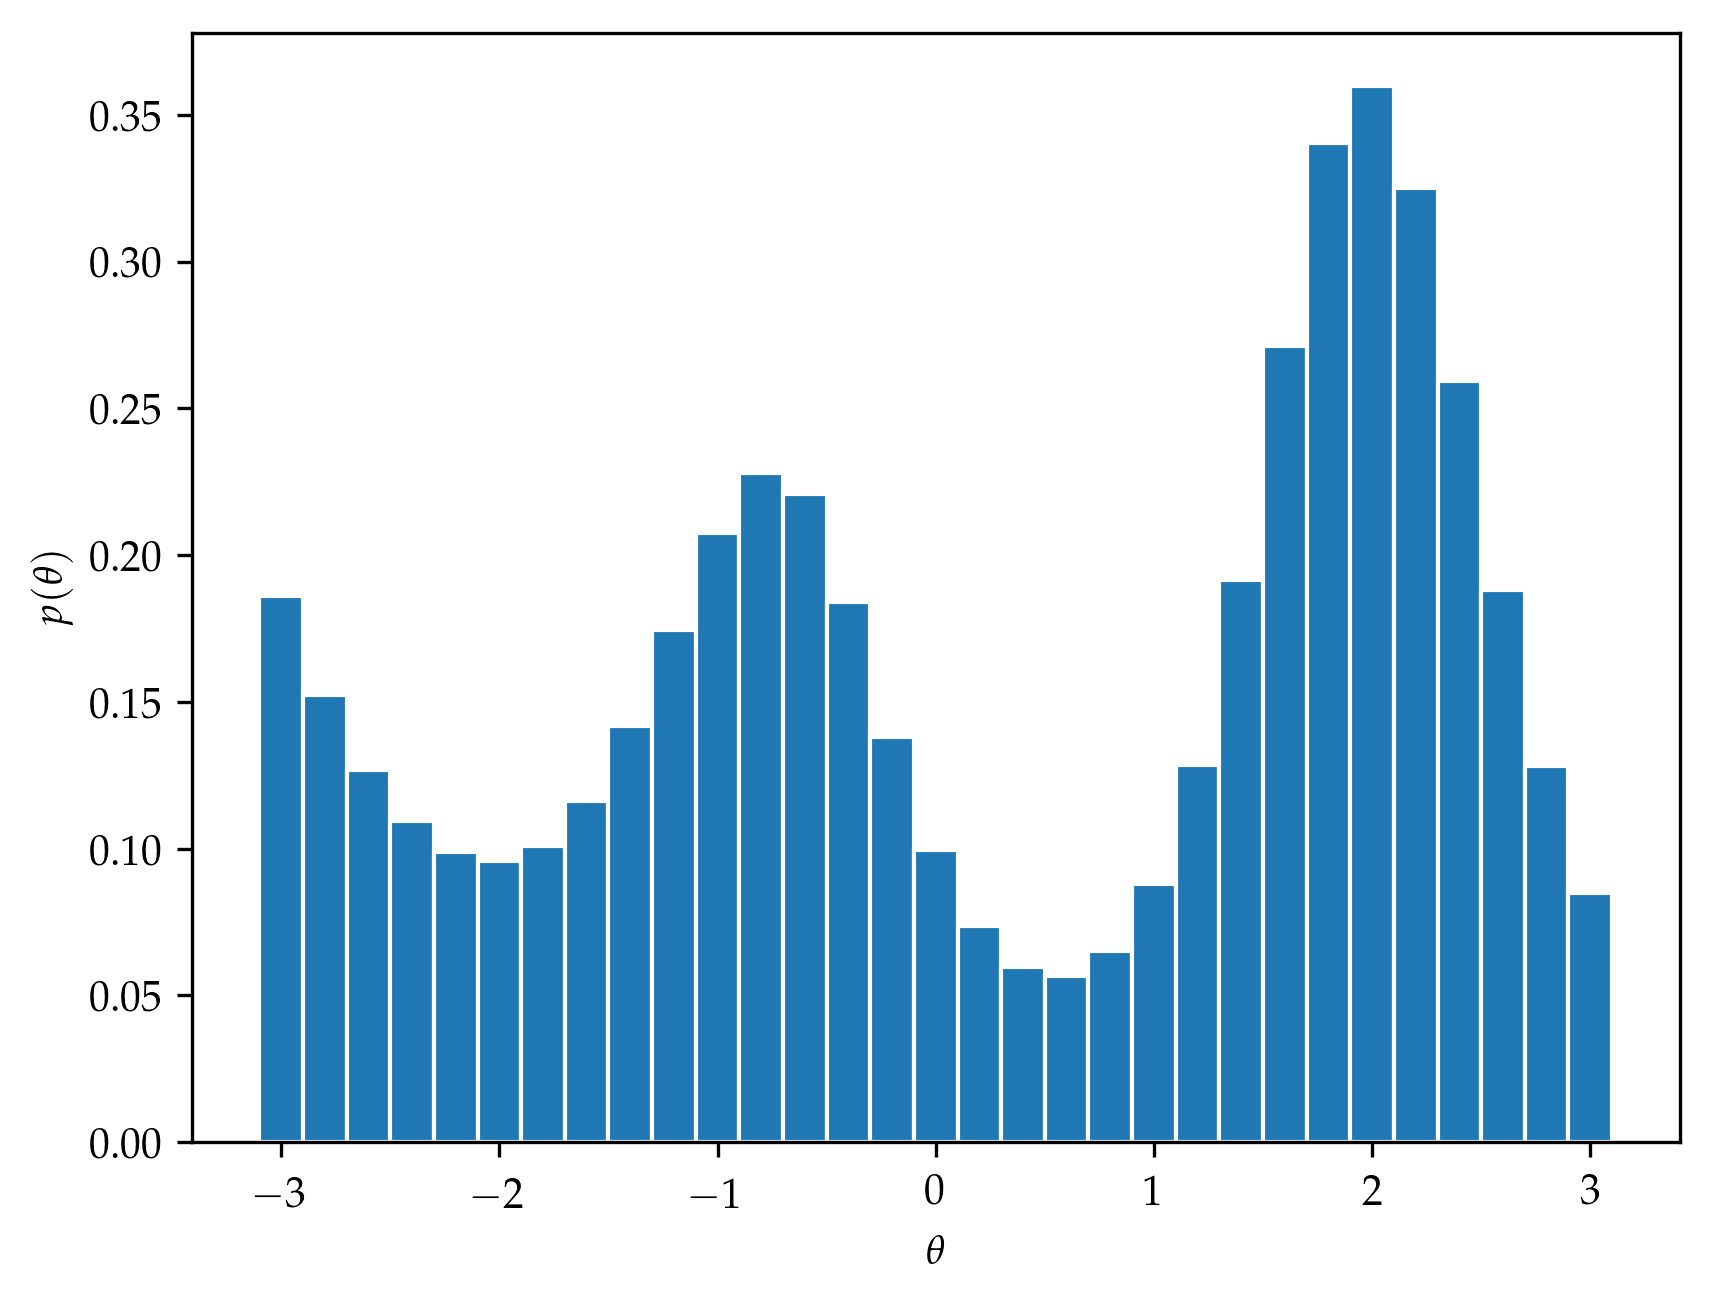

In [102]:
Random.seed!(3)
d = ExpoFamSpline.ExpoSpline(θvec, randn(5))
plot_pdf(d, edgecolor="white")
plt.xlabel(L"\theta")
plt.ylabel(L"p(\theta)")
;

# Convolution with observation distribution

> Let
> \begin{equation}
    p_{ij} = p_i(X_i \mid \Theta_i = \theta_j)
\end{equation}
> be the probability that $X_i$ equals its observed value if $\Theta_i$ equals $\theta_j$ and define $P_i$ to be the $m$-vector of possible such probabilities for $X_i$: $P_i=(p_{i1}, \dotsc, p_{im})\trans$.
> In our discrete setting, the marginal probability (6) for $X_i$ becomes
> \begin{equation}
    P(X_i \mid \alpha) = f_i(\alpha) = \sum_{j=1}^m p_{ij} g_j(\alpha) = P_i\trans g(\alpha)
    \,.
\end{equation}

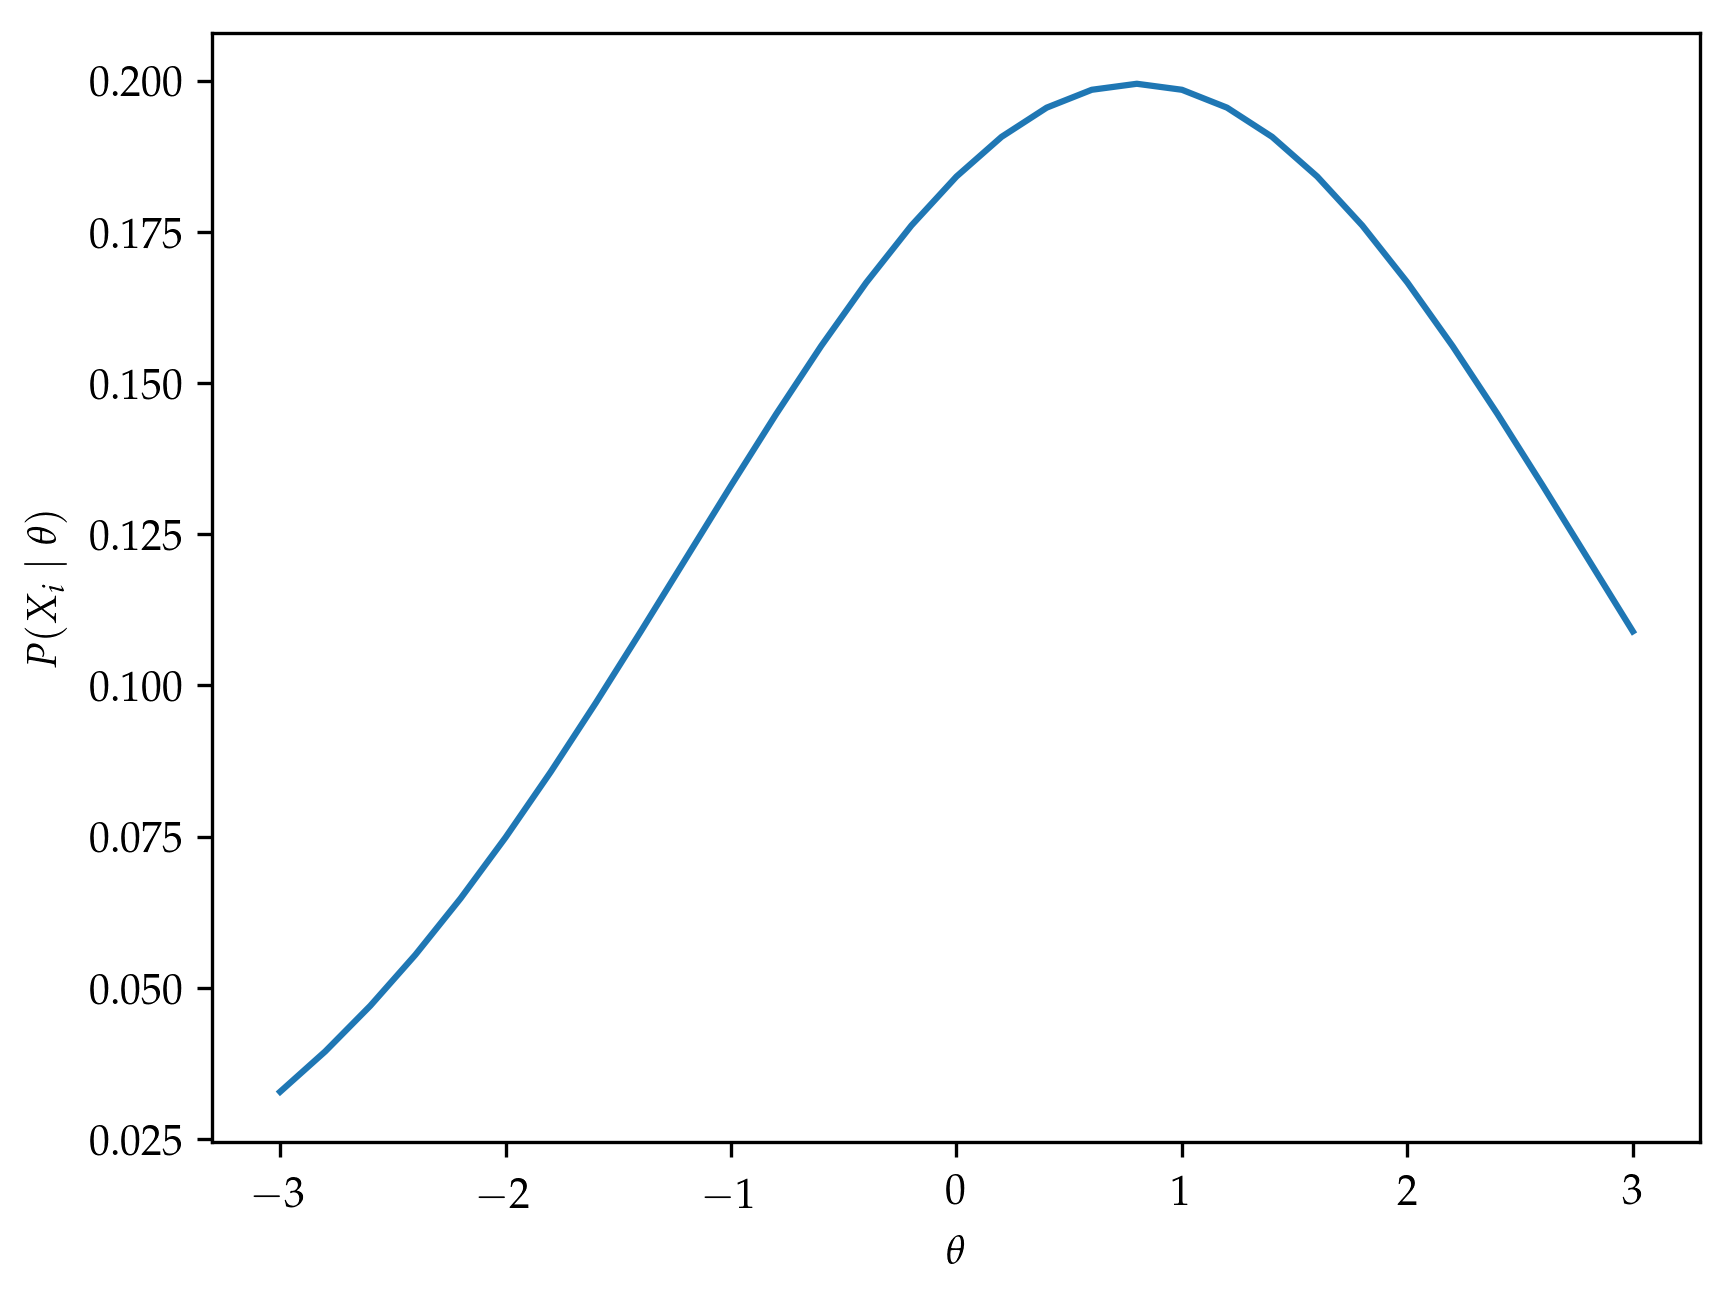

In [30]:
function get_Pi(Θdomain::Vector{Float64}, noise::UnivariateDistribution, X_i::Float64)
    # normalization?
    pdf.(noise, X_i.-Θdomain)
end
Pi = get_Pi(d.domain, Normal(0, 2), 0.8)
plt.plot(d.domain, Pi)
plt.xlabel(L"\theta")
plt.ylabel(L"P(X_i \mid \theta)")
;

In [31]:
ExpoFamSpline.loglikelihood(d, Normal(0, 2), 0.5)
@time ExpoFamSpline.loglikelihood(d, Normal(0, 2), 0.5)

  0.000010 seconds (8 allocations: 1008 bytes)


-1.9655355382132051

# Efron simulation

> Figure 1 illustrates an artificial deconvolution problem in which $g(\theta)$ is a mixture of one-eighth $\unif([-3,3])$ and seven-eighths $\normal(0, 0.5^2)$,
> \begin{equation}
    g(\theta) = \frac{1}{8} \frac{I_{(-3,3)}(\theta)}{6} 
    + \frac{7}{8} \frac{1}{(2\pi\sigma^2)^{1/2}}
      \exp\del{-\frac{1}{2}\frac{\theta^2}{\sigma^2}}
      ,\quad
      \sigma=0.5
      \,,
\end{equation}
> with normal observations $X_i \sim \normal(\Theta_i, 1)$ as in (5), a reduced case.

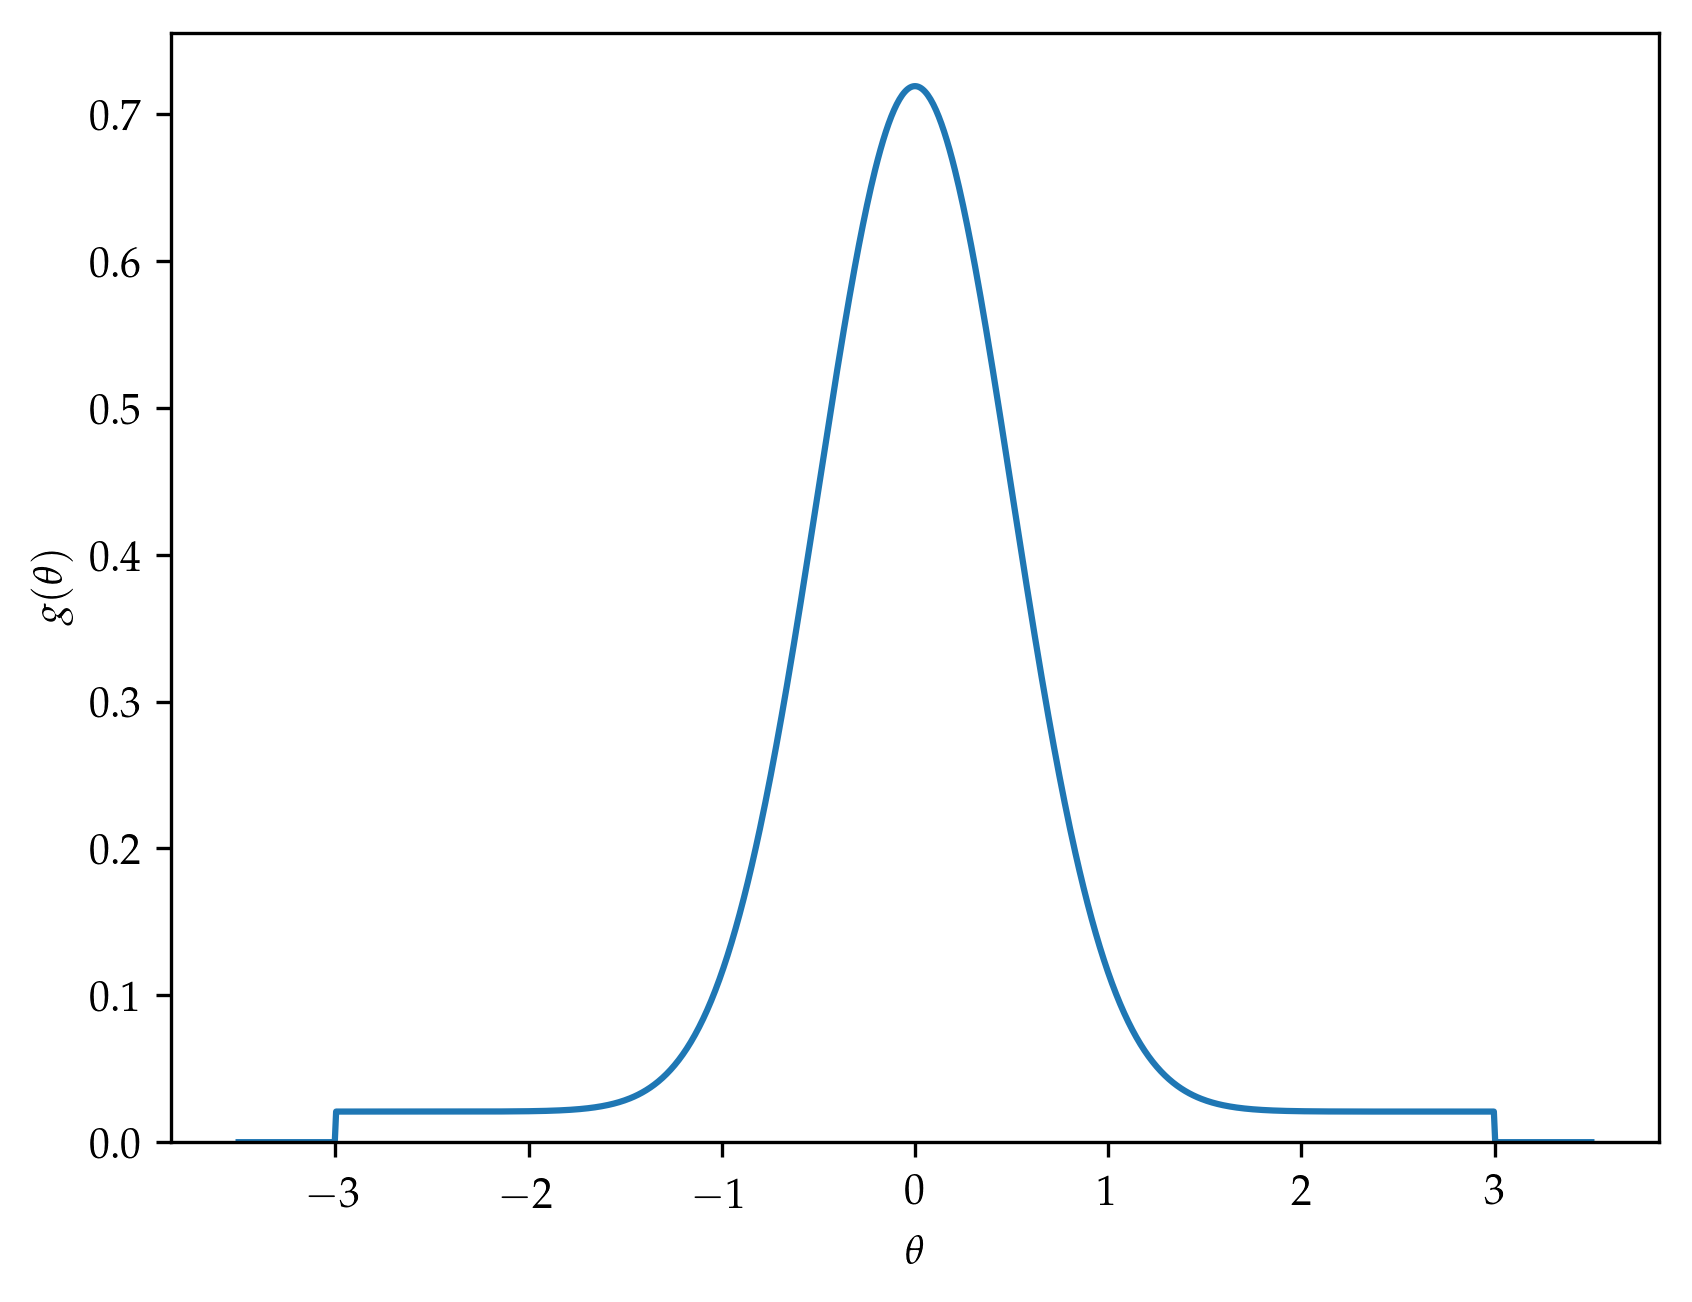

In [32]:
# Mixture models are very simple to create in julia:
example_gθ = MixtureModel(
        [Uniform(-3,3), Normal(0, 0.5)], # components
        [1/8, 7/8]                       # weights
        )
example_noise = Normal(0, 1)
xx = range(-3.5, stop=3.5, length=1000)
plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.ylabel(L"g(\theta)")
plt.xlabel(L"\theta")
plt.ylim(0.0)
;

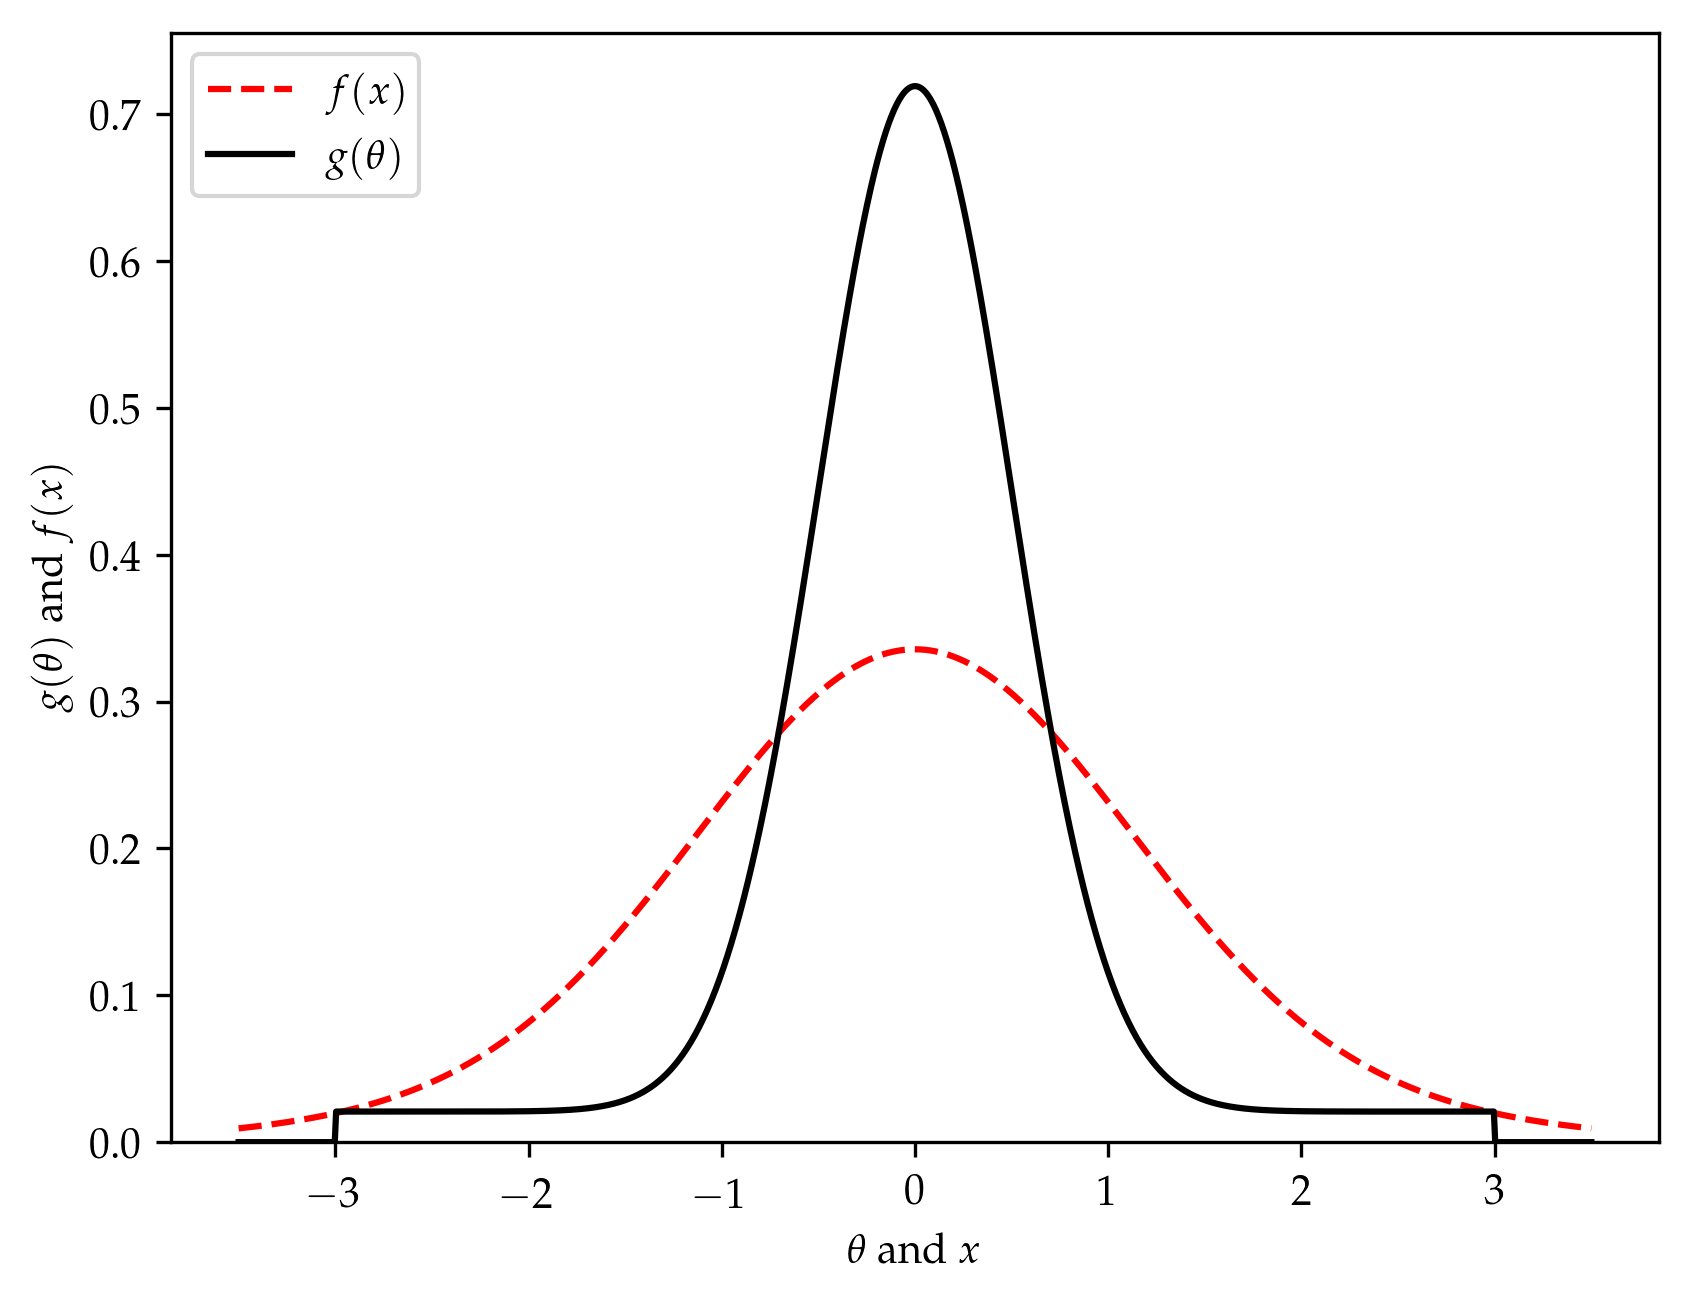

In [33]:
function convolved_log_fx(gθ::Distribution, θgrid::AbstractVector{Float64}, noise::Distribution, x_i::Float64)
    gθ_lpdf = logpdf.(gθ, θgrid)
    noise_lpdf = logpdf.(noise, x_i.-θgrid)
    return ExpoFamSpline.log_sum_exp(gθ_lpdf .+ noise_lpdf)
end

f_x_unnormalised = exp.([convolved_log_fx(example_gθ, range(-3.0, stop=3.0, length=41), example_noise, x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"f(x)", color="red", linestyle="--")
plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)", color="black")
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.ylim(0.0)
plt.legend(loc="upper left")
;

In [34]:
N = 1000
Random.seed!(1)
θ_sim = rand(example_gθ, N)
X_sim = θ_sim .+ rand(example_noise, N)
;

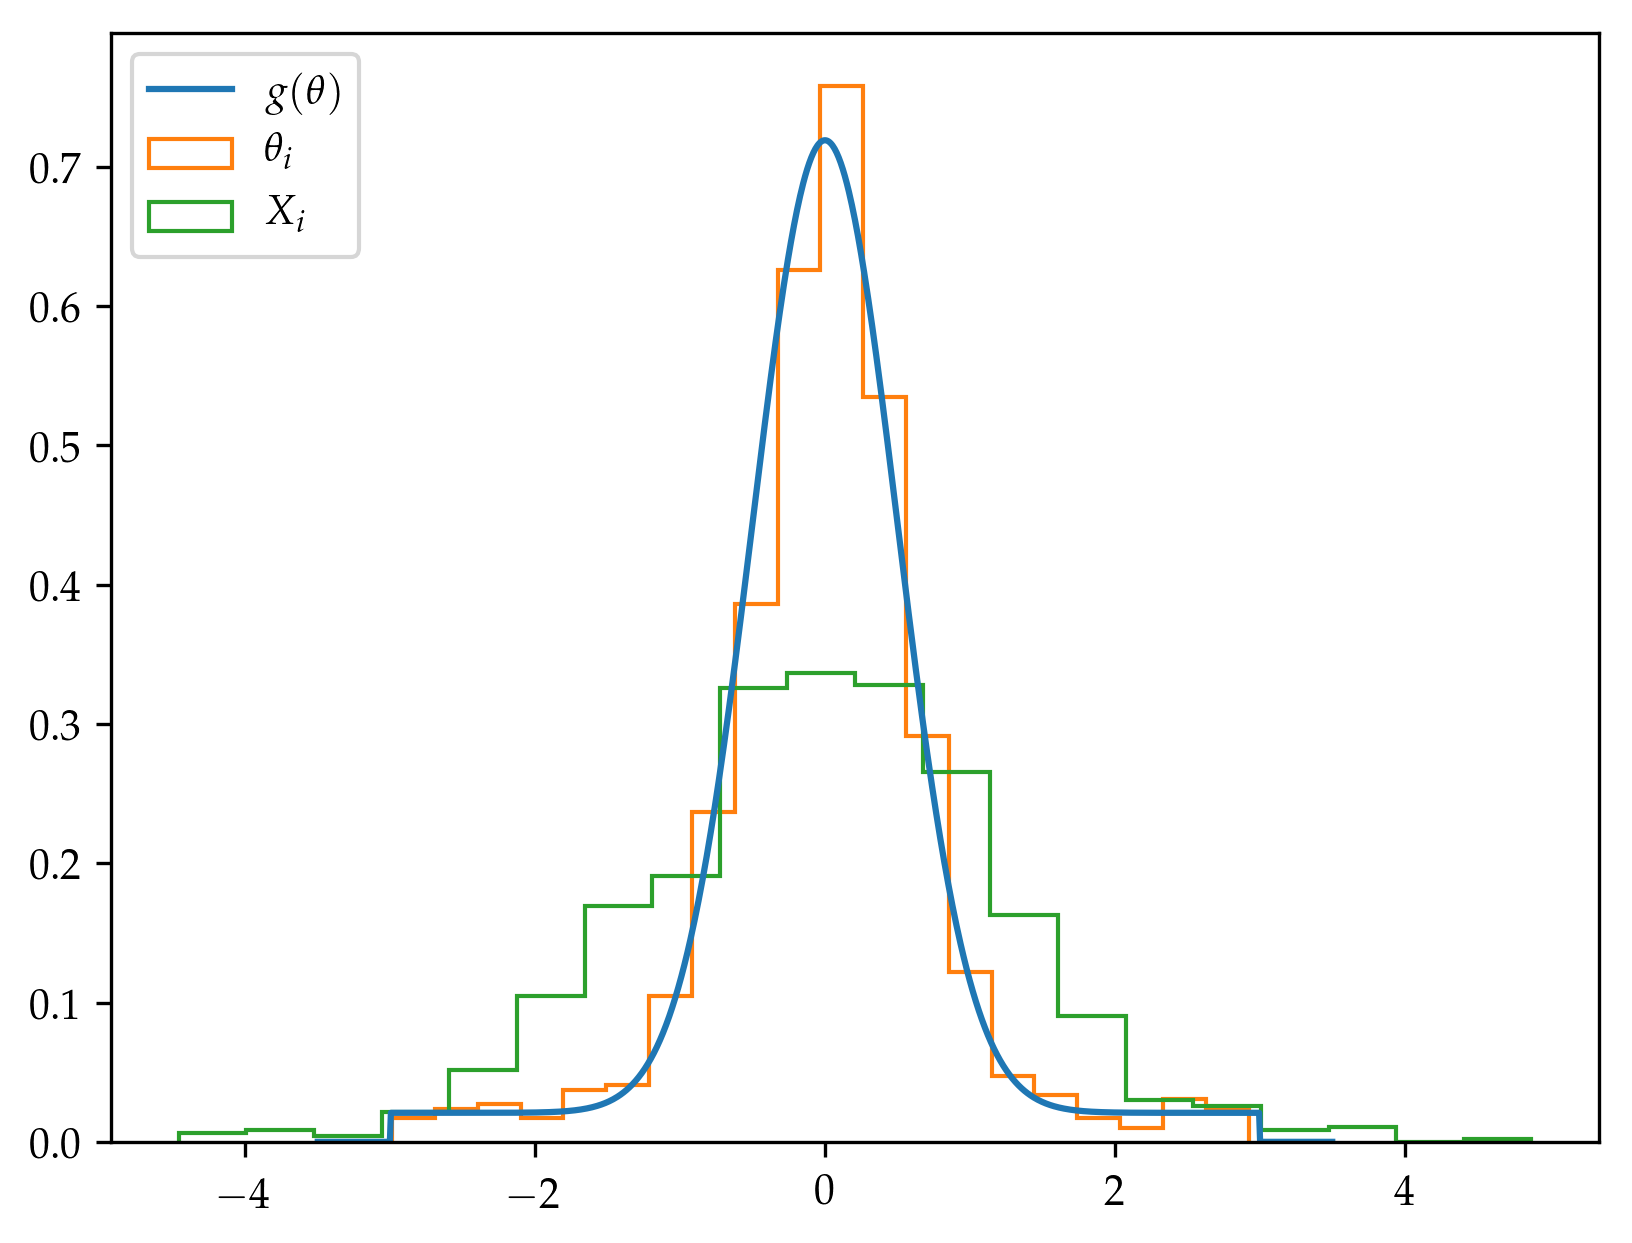

In [35]:
plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.plt[:hist](θ_sim, histtype="step", normed=true, label=L"\theta_i", bins=20)
plt.plt[:hist](X_sim, histtype="step", normed=true, label=L"X_i", bins=20)
plt.legend(loc="upper left")
;

# Spline log-likelihood

## noise-free

In [36]:
# noise-free
sum(logpdf.(d, θ_sim))

-3826.888362542397

In [37]:
@time sum(logpdf.(d, θ_sim));

  0.000239 seconds (1.01 k allocations: 398.797 KiB)


## noisy

In [38]:
sum(ExpoFamSpline.loglikelihood.(d, example_noise, X_sim))

-1955.6564909358706

In [39]:
@time sum(ExpoFamSpline.loglikelihood.(d, example_noise, X_sim));

  0.001137 seconds (2.01 k allocations: 789.484 KiB)


# Autodifferentiation of log-likelihood

Here we obtain the gradient of the noise-free log-likelihood using forward auto-differentiation.

## noise-free

In [43]:
# create likelihood function
likelihood = α -> sum(logpdf.(ExpoFamSpline.ExpoSpline(θvec, d.Qbasis, α), θ_sim))
likelihood(coefs(d))

-3826.888362542397

In [44]:
ForwardDiff.gradient(likelihood, coefs(d))

5-element Array{Float64,1}:
  213.16906504243542
  262.689847860778  
 -122.87136046753952
 -148.6756464833139 
  -39.11676228566872

On my computer, it takes less than 1 millisecond to compute the noise-free gradient of the log-likelihood with 1,000 simulated observations.

In [45]:
@time ForwardDiff.gradient(likelihood, coefs(d));

  0.000269 seconds (1.02 k allocations: 440.266 KiB)


## noisy

In [46]:
loglik_w_noise = α -> sum(
    ExpoFamSpline.loglikelihood.(
        ExpoFamSpline.ExpoSpline(
            θvec, 
            d.Qbasis, 
            α), 
        example_noise, 
        X_sim))
loglik_w_noise(coefs(d))

-1955.6564909358706

In [47]:
ForwardDiff.gradient(loglik_w_noise, coefs(d))

5-element Array{Float64,1}:
 101.98929956279108 
  52.466954710440305
 -42.00395137905551 
 -27.75961531336918 
 -56.6428913791185  

On my computer, it takes about 6 milliseconds to compute the noise-free gradient of the log-likelihood with 1,000 simulated observations.

In [49]:
ForwardDiff.gradient(loglik_w_noise, coefs(d))
@time for _ in 1:100;ForwardDiff.gradient(loglik_w_noise, coefs(d));end;

  0.215139 seconds (203.20 k allocations: 198.718 MiB, 18.61% gc time)


**Pre-compute $P_i$'s**

In [50]:
# convenience function to make optimization target
function make_loglik_w_noise_pre(d::ExpoFamSpline.ExpoSpline, noise, X::Vector{Float64})
    logP = ExpoFamSpline.get_logPi.(d, noise, X)
    mloglik_w_noise_pre = (α) -> -sum(ExpoFamSpline.loglikelihood.(
        ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, α), 
        logP))
    return mloglik_w_noise_pre
end

make_loglik_w_noise_pre (generic function with 1 method)

In [51]:
f = make_loglik_w_noise_pre(d, example_noise, X_sim)
f(coefs(d))

1955.6564909358706

It's a little bit faster (4 ms instead of 6 ms).

In [52]:
ForwardDiff.gradient(f, coefs(d))

5-element Array{Float64,1}:
 -101.98929956279108 
  -52.466954710440305
   42.00395137905551 
   27.75961531336918 
   56.6428913791185  

In [54]:
@time for _ in 1:100;ForwardDiff.gradient(f, coefs(d));end;

  0.176339 seconds (102.80 k allocations: 160.561 MiB, 19.02% gc time)


# Analytical differentiation of log-likelihood

In [58]:
function make_dloglik(d::ExpoFamSpline.ExpoSpline, noise, X::Vector{Float64})
    logP = ExpoFamSpline.get_logPi.(d, noise, X)
    dloglik = function(α::Vector{Float64})
        d_α = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, α)
        gradient = zero(coefs(d))
        for i in 1:length(X)
            gradient .+= ExpoFamSpline.dloglik(d_α, logP[i])
        end
        return gradient
    end
    return dloglik
end     

make_dloglik (generic function with 1 method)

In [59]:
df = make_dloglik(d, example_noise, X_sim)
df(coefs(d)) # same as autodiff answer (up to sign difference)

5-element Array{Float64,1}:
 101.98929956279108 
  52.466954710440284
 -42.00395137905534 
 -27.759615313369185
 -56.64289137911845 

In [61]:
@time for _ in 1:100;df(coefs(d)) ;end;

  0.237874 seconds (500.30 k allocations: 93.134 MiB, 11.87% gc time)


## hessian

In [73]:
function make_d2loglik(d::ExpoFamSpline.ExpoSpline, noise, X::Vector{Float64})
    logP = ExpoFamSpline.get_logPi.(d, noise, X)
    npars = length(coefs(d))
    d2loglik = function(α::Vector{Float64})
        d_α = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, α)
        hess = zeros(npars, npars)
        for i in 1:length(X)
            hess .+= ExpoFamSpline.d2loglik(d_α, logP[i])
        end
        return hess
    end
    return d2loglik
end     

make_d2loglik (generic function with 2 methods)

In [74]:
ForwardDiff.hessian(f, coefs(d))

5×5 Array{Float64,2}:
   9.85629   6.36771   -11.3769    1.04398  -18.7293 
   6.36771  -0.697489    7.54292   1.1243    -4.74999
 -11.3769    7.54292    38.6624   -3.57929   17.8103 
   1.04398   1.1243     -3.57929   1.30834    5.55984
 -18.7293   -4.74999    17.8103    5.55984   32.7825 

In [75]:
@time ForwardDiff.hessian(f, coefs(d));

  0.007480 seconds (1.04 k allocations: 8.957 MiB)


In [76]:
d2f = make_d2loglik(d, example_noise, X_sim)
d2f(coefs(d)) # should be same as autodiff answer

┌ Warning: `diagm(v::AbstractVector)` is deprecated, use `diagm(0 => v)` or `Matrix(Diagonal(v))` instead.
│   caller = d2loglik(::Main.ExpoFamSpline.ExpoSpline{Float64}, ::Array{Float64,1}) at In[70]:98
└ @ Main.ExpoFamSpline ./In[70]:98


5×5 Array{Float64,2}:
 -9.85629  -6.36771    11.3769   -1.04398   18.7293 
 -6.36771   0.697489   -7.54292  -1.1243     4.74999
 11.3769   -7.54292   -38.6624    3.57929  -17.8103 
 -1.04398  -1.1243      3.57929  -1.30834   -5.55984
 18.7293    4.74999   -17.8103   -5.55984  -32.7825 

In [77]:
@time d2f(coefs(d)) # should be same as autodiff answer

  0.170140 seconds (91.01 k allocations: 60.243 MiB, 10.51% gc time)


5×5 Array{Float64,2}:
 -9.85629  -6.36771    11.3769   -1.04398   18.7293 
 -6.36771   0.697489   -7.54292  -1.1243     4.74999
 11.3769   -7.54292   -38.6624    3.57929  -17.8103 
 -1.04398  -1.1243      3.57929  -1.30834   -5.55984
 18.7293    4.74999   -17.8103   -5.55984  -32.7825 

We get the same answer using analytical gradients and Hessians as using forward autodifferentiation, and the performance is about the same.
It might be possible to rewrite the derivative code but I'm not convinced it's worth the effort over using autodifferentiation.

# Optimize log-likelihood

## fitting noise-free data

In [87]:
f = ExpoFamSpline.make_loglik_noisefree(d, θ_sim)
td = TwiceDifferentiable(f, copy(coefs(d)); autodiff=:forward)
nf_opt_out = optimize(td, zero(coefs(d)), Optim.Newton()) # compile
@time nf_opt_out = optimize(td, zero(coefs(d)), Optim.Newton())

  0.013235 seconds (18.35 k allocations: 8.920 MiB, 77.49% gc time)


Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [0.0,0.0,0.0,0.0,0.0]
 * Minimizer: [3.412683227888655,3.9627589346833383, ...]
 * Minimum: 2.669621e+03
 * Iterations: 5
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 9.46e-05 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 2.17e-11 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 8.02e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 26
 * Gradient Calls: 26
 * Hessian Calls: 10

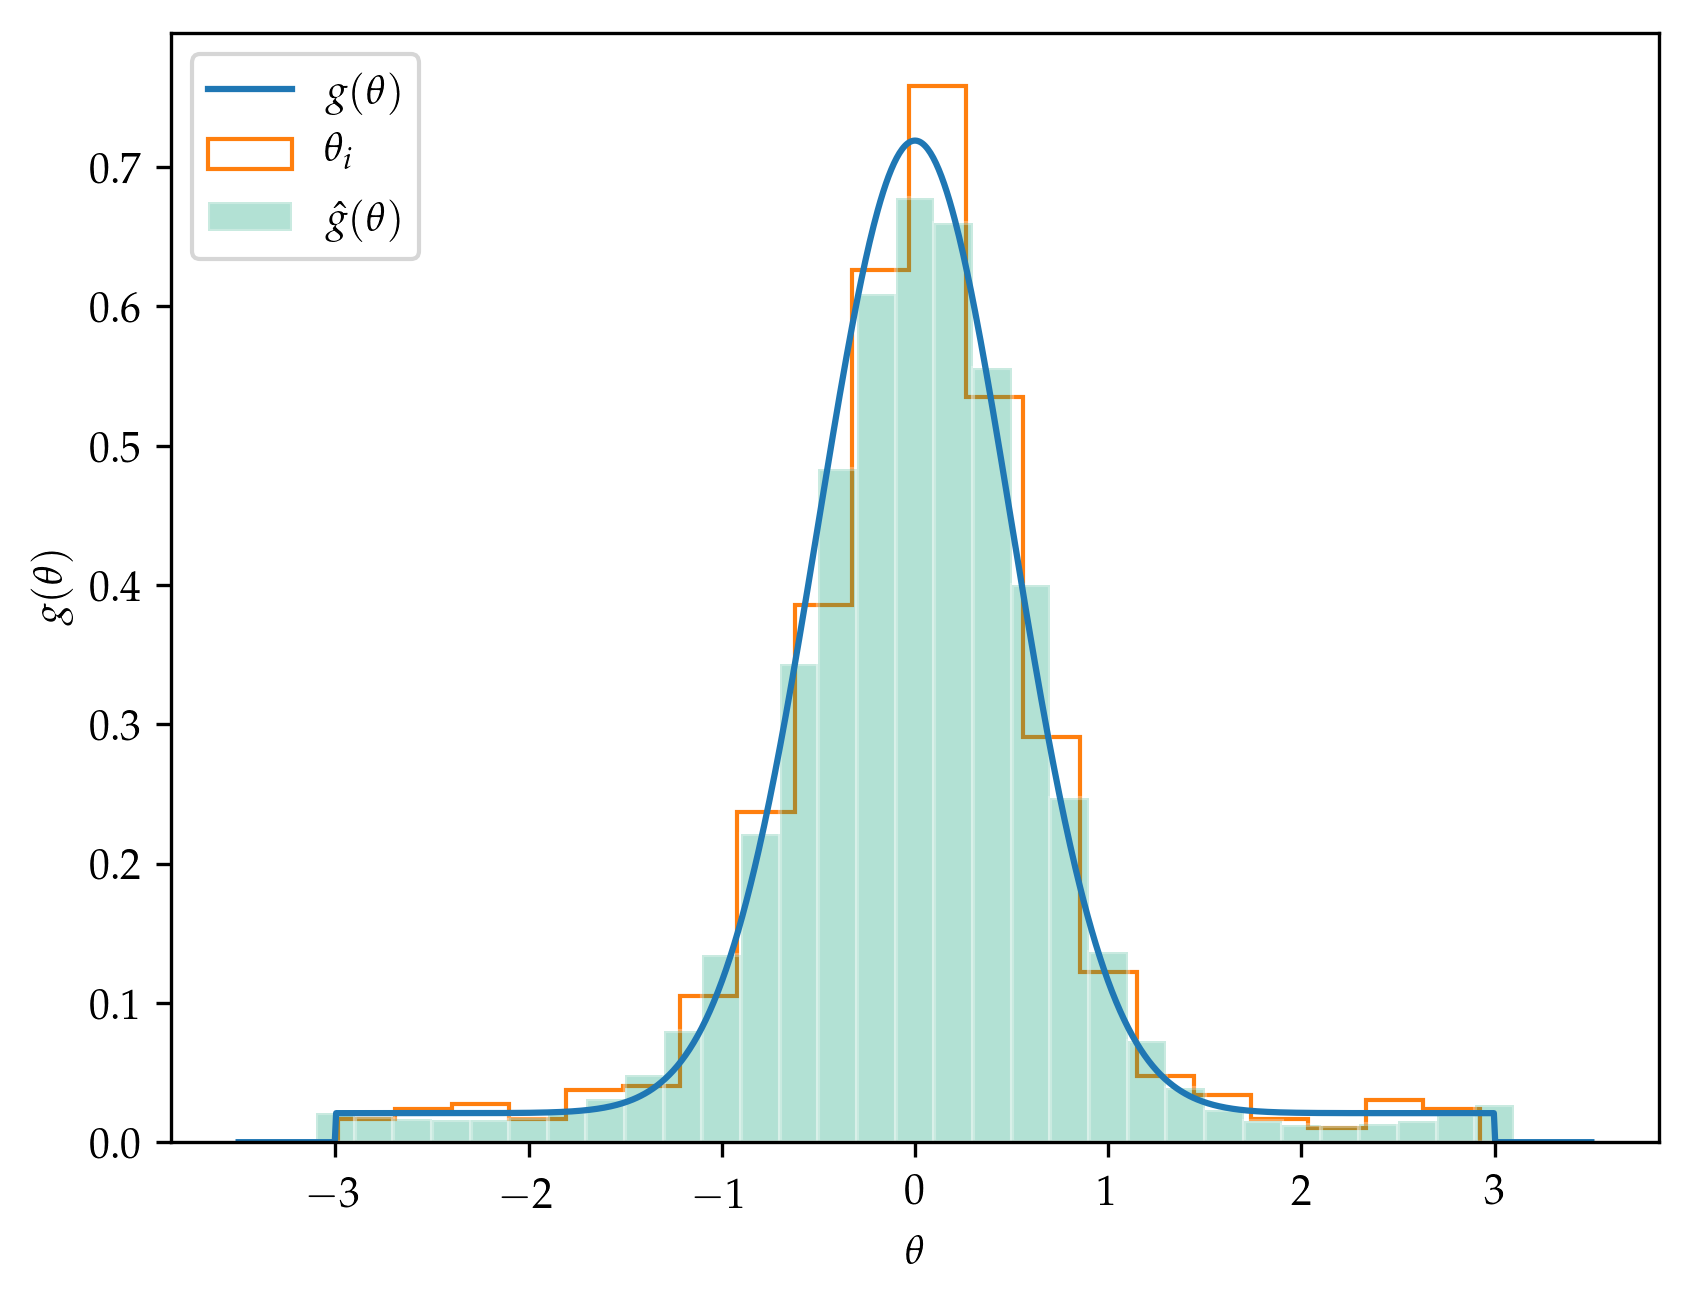

In [88]:
nf_optim = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, Optim.minimizer(nf_opt_out))

plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.plt[:hist](θ_sim, histtype="step", normed=true, label=L"\theta_i", bins=20)
_ylim = plt.ylim()
plot_pdf(nf_optim, label=L"\hat{g}(\theta)"; facecolor=cbbPalette[3], edgecolor="white", alpha=0.3)
plt.ylim(_ylim)
plt.ylabel(L"$g(\theta)$")
plt.xlabel(L"$\theta$")
plt.legend(loc="upper left")
;

## fitting noisy data

In [91]:
f = ExpoFamSpline.make_loglik_w_noise_pre(d, example_noise, X_sim)
td = TwiceDifferentiable(f, copy(coefs(d)); autodiff=:forward)
opt_out = optimize(td, zero(coefs(d)), Optim.ConjugateGradient())
@time opt_out = optimize(td, zero(coefs(d)), Optim.ConjugateGradient())

  0.423629 seconds (357.78 k allocations: 367.834 MiB, 9.07% gc time)


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0,0.0,0.0,0.0]
 * Minimizer: [2.4907837671258655,5.278800660762035, ...]
 * Minimum: 1.622219e+03
 * Iterations: 155
 * Convergence: false
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 4.48e-07 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 2.80e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.59e-06 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 678
 * Gradient Calls: 396

In [92]:
f = ExpoFamSpline.make_loglik_w_noise_pre(d, example_noise, X_sim)
td = TwiceDifferentiable(f, copy(coefs(d)); autodiff=:forward)
opt_out = optimize(td, zero(coefs(d)), Optim.BFGS())
@time opt_out = optimize(td, zero(coefs(d)), Optim.BFGS())
# doesn't reach the minimum! boo!

  0.588153 seconds (384.31 k allocations: 590.652 MiB, 9.48% gc time)


Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.0,0.0,0.0,0.0,0.0]
 * Minimizer: [2.490781612138513,5.278798858800052, ...]
 * Minimum: 1.622219e+03
 * Iterations: 110
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 5.03e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.82e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 4.63e-11 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 758
 * Gradient Calls: 758

In [93]:
f = ExpoFamSpline.make_loglik_w_noise_pre(d, example_noise, X_sim)
td = TwiceDifferentiable(f, copy(coefs(d)); autodiff=:forward)
opt_out = optimize(td, zero(coefs(d)), Optim.Newton())
@time opt_out = optimize(td, zero(coefs(d)), Optim.Newton())

  0.264308 seconds (125.80 k allocations: 335.630 MiB, 12.82% gc time)


Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [0.0,0.0,0.0,0.0,0.0]
 * Minimizer: [2.4907815922854137,5.278798941734838, ...]
 * Minimum: 1.622219e+03
 * Iterations: 20
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 9.97e-05 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 6.97e-12 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 8.77e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 208
 * Gradient Calls: 208
 * Hessian Calls: 40

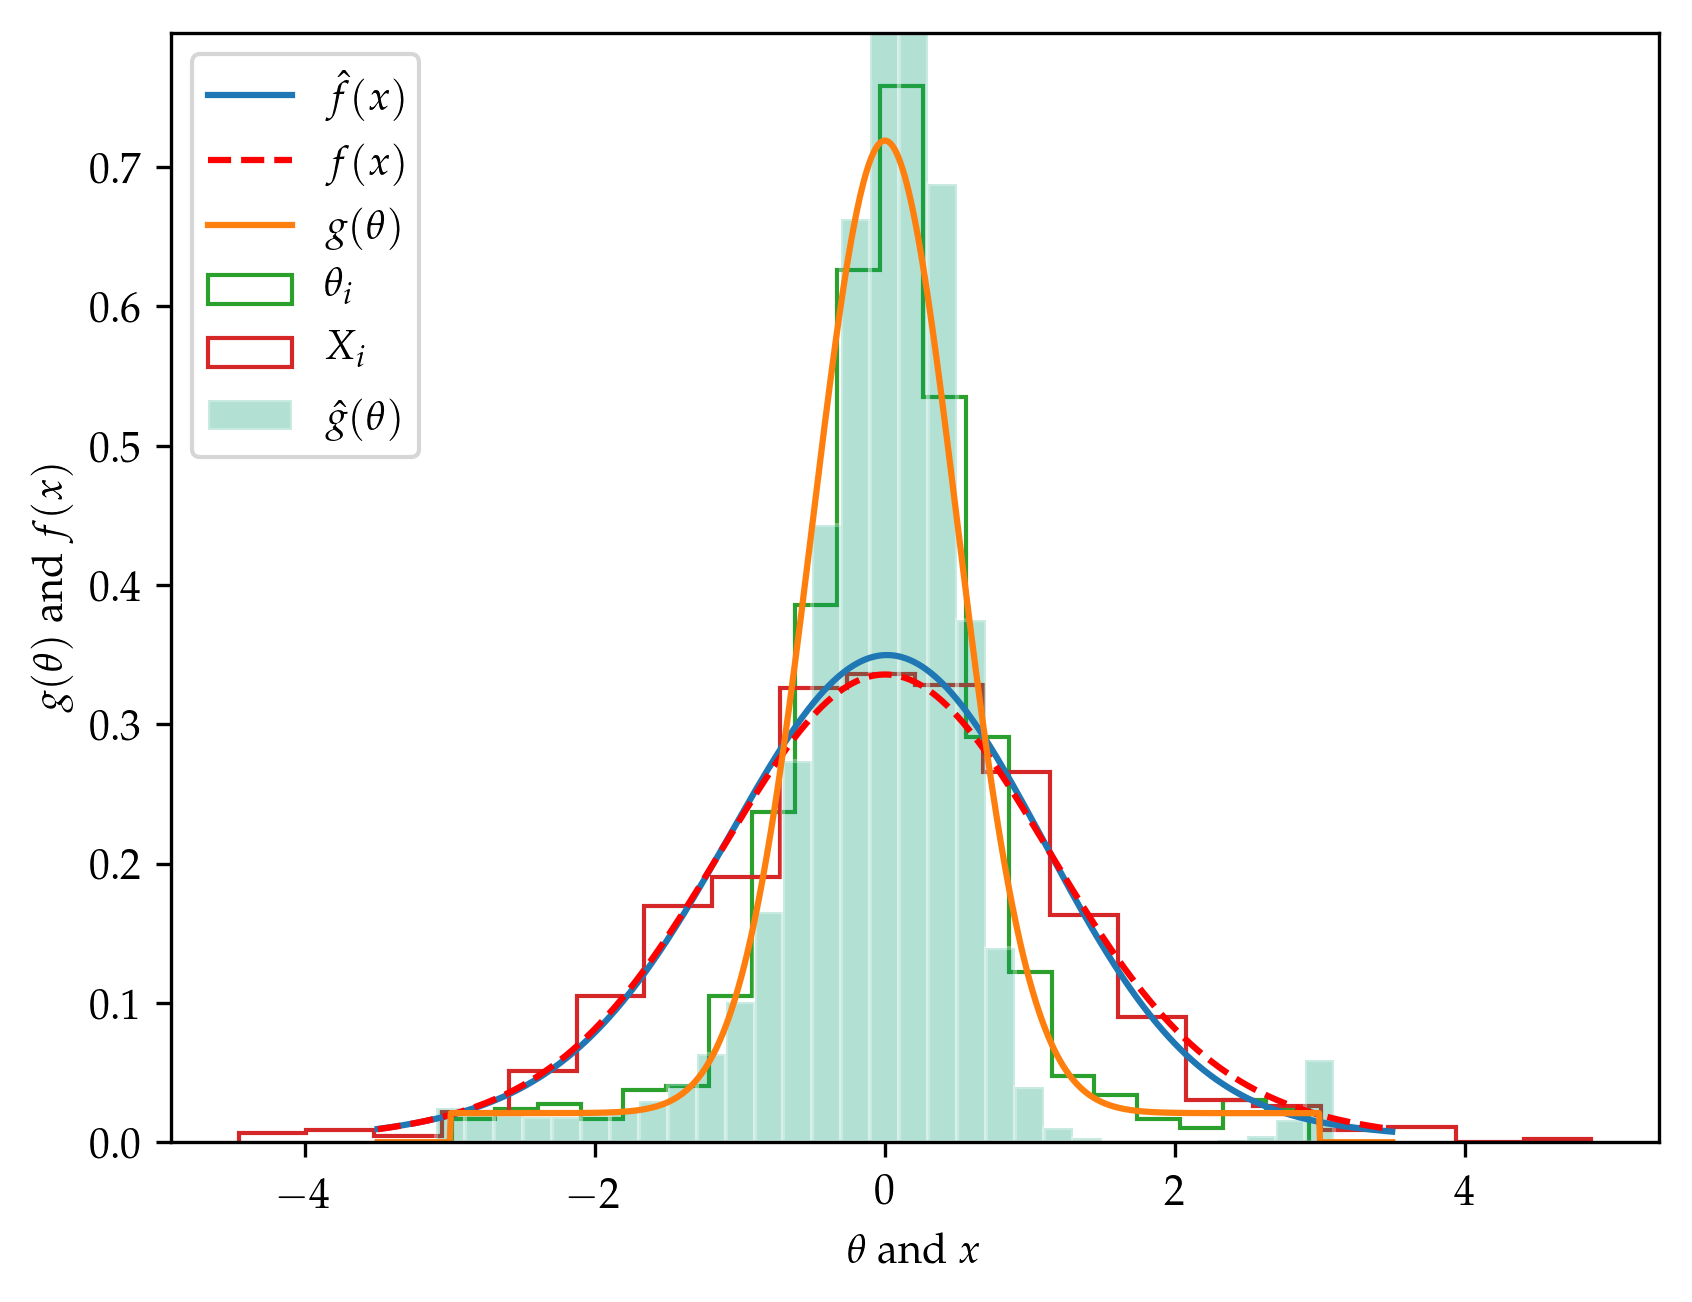

In [97]:
d_optim = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, Optim.minimizer(opt_out))

f_x_unnormalised = exp.([convolved_log_fx(d_optim, d_optim.domain, example_noise, x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"\hat{f}(x)")

f_x_unnormalised = exp.([convolved_log_fx(example_gθ, range(-3.0, stop=3.0, length=51), example_noise, x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"f(x)", color="red", linestyle="--")

plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.plt[:hist](θ_sim, histtype="step", normed=true, label=L"\theta_i", bins=20)
plt.plt[:hist](X_sim, histtype="step", normed=true, label=L"X_i", bins=20)
_ylim = plt.ylim()
plot_pdf(d_optim, label=L"\hat{g}(\theta)"; facecolor=cbbPalette[3], alpha=0.3, edgecolor="white")
plt.ylim(_ylim)
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.legend(loc="upper left")
;

# Repeat 500 times

> This whole procedure was independently repeated 500 times, yielding estimates $\hat{g}^{(1)}, \dotsc, \hat{g}^{(500)}$, with means and standard deviations of the component values $\hat{g}_j$ given by $$
    \bar{g}_j = \sum_{b=1}^{500} \hat{g}_j^{(b)} / 500
    ,\quad
    \mathrm{sd}_j = \cbr{
        \sum_{b=1}^{500} 
        \del{
            \hat{g}_j^{(b)} - \bar{g}_j
        }^2 / 499
    }^{1/2}
$$

In [103]:
function repeat_efron_example(; regularized::Bool=false)
    N = 1000
    θ = rand(example_gθ, N)
    X = θ .+ rand(example_noise, N)
    d = ExpoFamSpline.ExpoSpline(θvec, randn(5))
    if regularized
        c0 = 2
        f = ExpoFamSpline.make_penalized_w_noise_pre(d, example_noise, X, c0)
    else
        f = ExpoFamSpline.make_loglik_w_noise_pre(d, example_noise, X)
    end
    td = TwiceDifferentiable(f, copy(coefs(d)); autodiff=:forward)
    opt_out = optimize(td, zero(coefs(d)), Optim.Newton())
    for attempt in 1:5
        if Optim.converged(opt_out)
            break
        end
        # try again with new starting point
        opt_out = optimize(td, randn(length(coefs(d))), Optim.Newton())
    end
    @assert Optim.converged(opt_out)
    return Optim.minimizer(opt_out)
end
Random.seed!(1)
repeat_efron_example(; regularized=false)

5-element Array{Float64,1}:
  2.4907815922854137
  5.278798941734838 
 -6.986879972192562 
 -2.4163527623532803
  1.2980068841153625

In [104]:
Random.seed!(1)
repeat_efron_example(; regularized=true)

5-element Array{Float64,1}:
  3.376612431922466 
  3.355862762311414 
 -1.387142121221145 
 -2.289244343794889 
  0.5197660170272932

In [105]:
@time α_fitted_500 = [repeat_efron_example() for _ in 1:500];

In [114]:
ghat_b = Matrix{Float64}(undef, 500, length(d.domain))
for b in 1:500
    α_hat = α_fitted_500[b]
    d_hat = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, α_hat)
    ghat = pdf(d_hat)
    ghat_b[b,:] = ghat
end

In [115]:
sum(pdf.(example_gθ, xx) .* median(diff(xx)))

0.9999582916228281

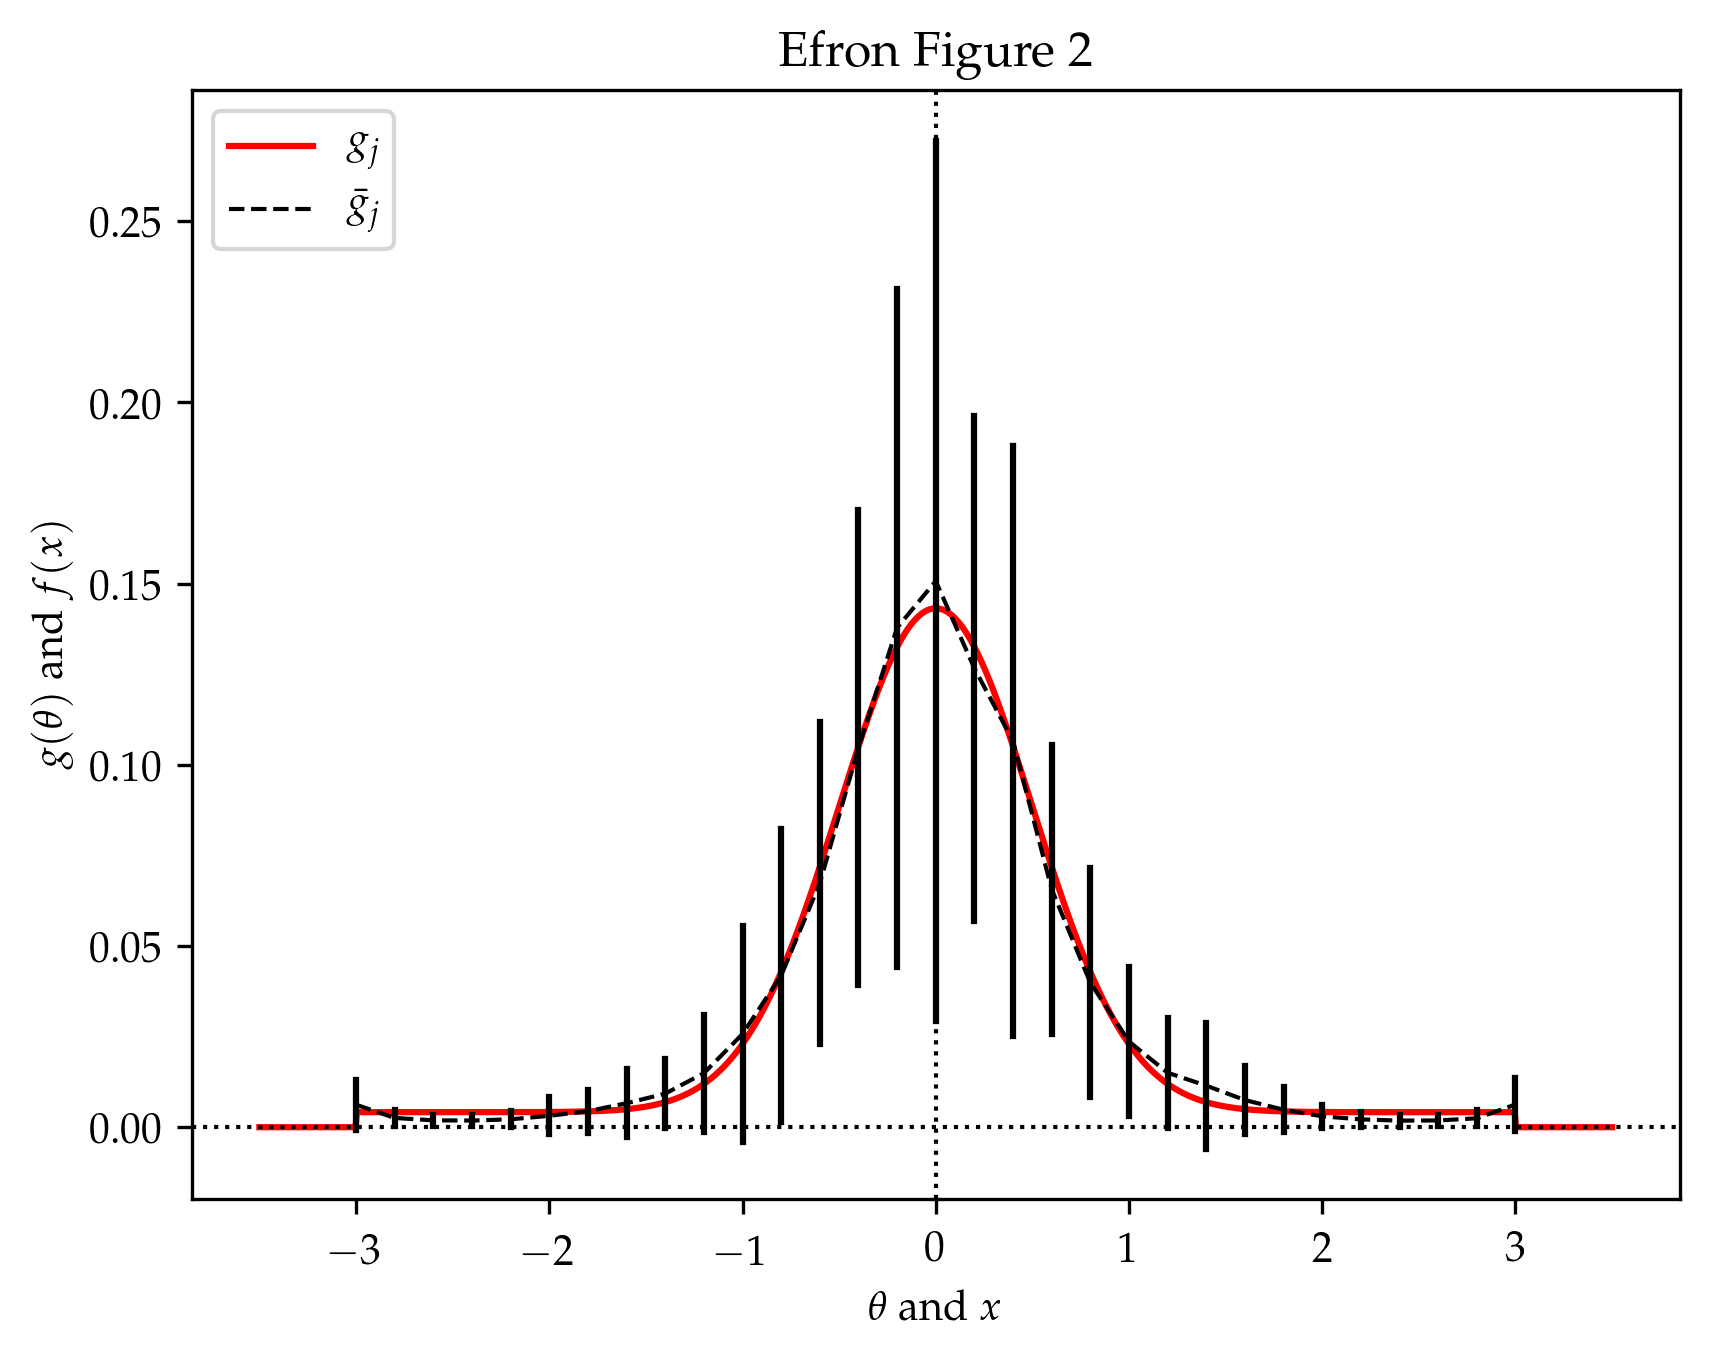

In [116]:
gbar = vec(mean(ghat_b, dims=1))
gstd = vec(std(ghat_b, dims=1))
g_true = pdf.(example_gθ, xx) ./ sum(pdf.(example_gθ, d.domain))
plt.plot(xx, g_true, label=L"g_j", color="red")
plt.plot(d.domain, gbar, label=L"\bar{g}_j", color="black", linewidth=1, linestyle="--")
for j in 1:length(d.domain)
    plt.plot([d.domain[j], d.domain[j]], [gbar[j]-gstd[j], gbar[j]+gstd[j]], "-", color="black")
end
plt.axvline(0.0, linestyle=":", color="black", linewidth=1)
plt.axhline(0.0, linestyle=":", color="black", linewidth=1)
# plt.fill_between(d.domain, gbar .- gstd, gbar .+ gstd)
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.legend(loc="upper left")
plt.title("Efron Figure 2")
;

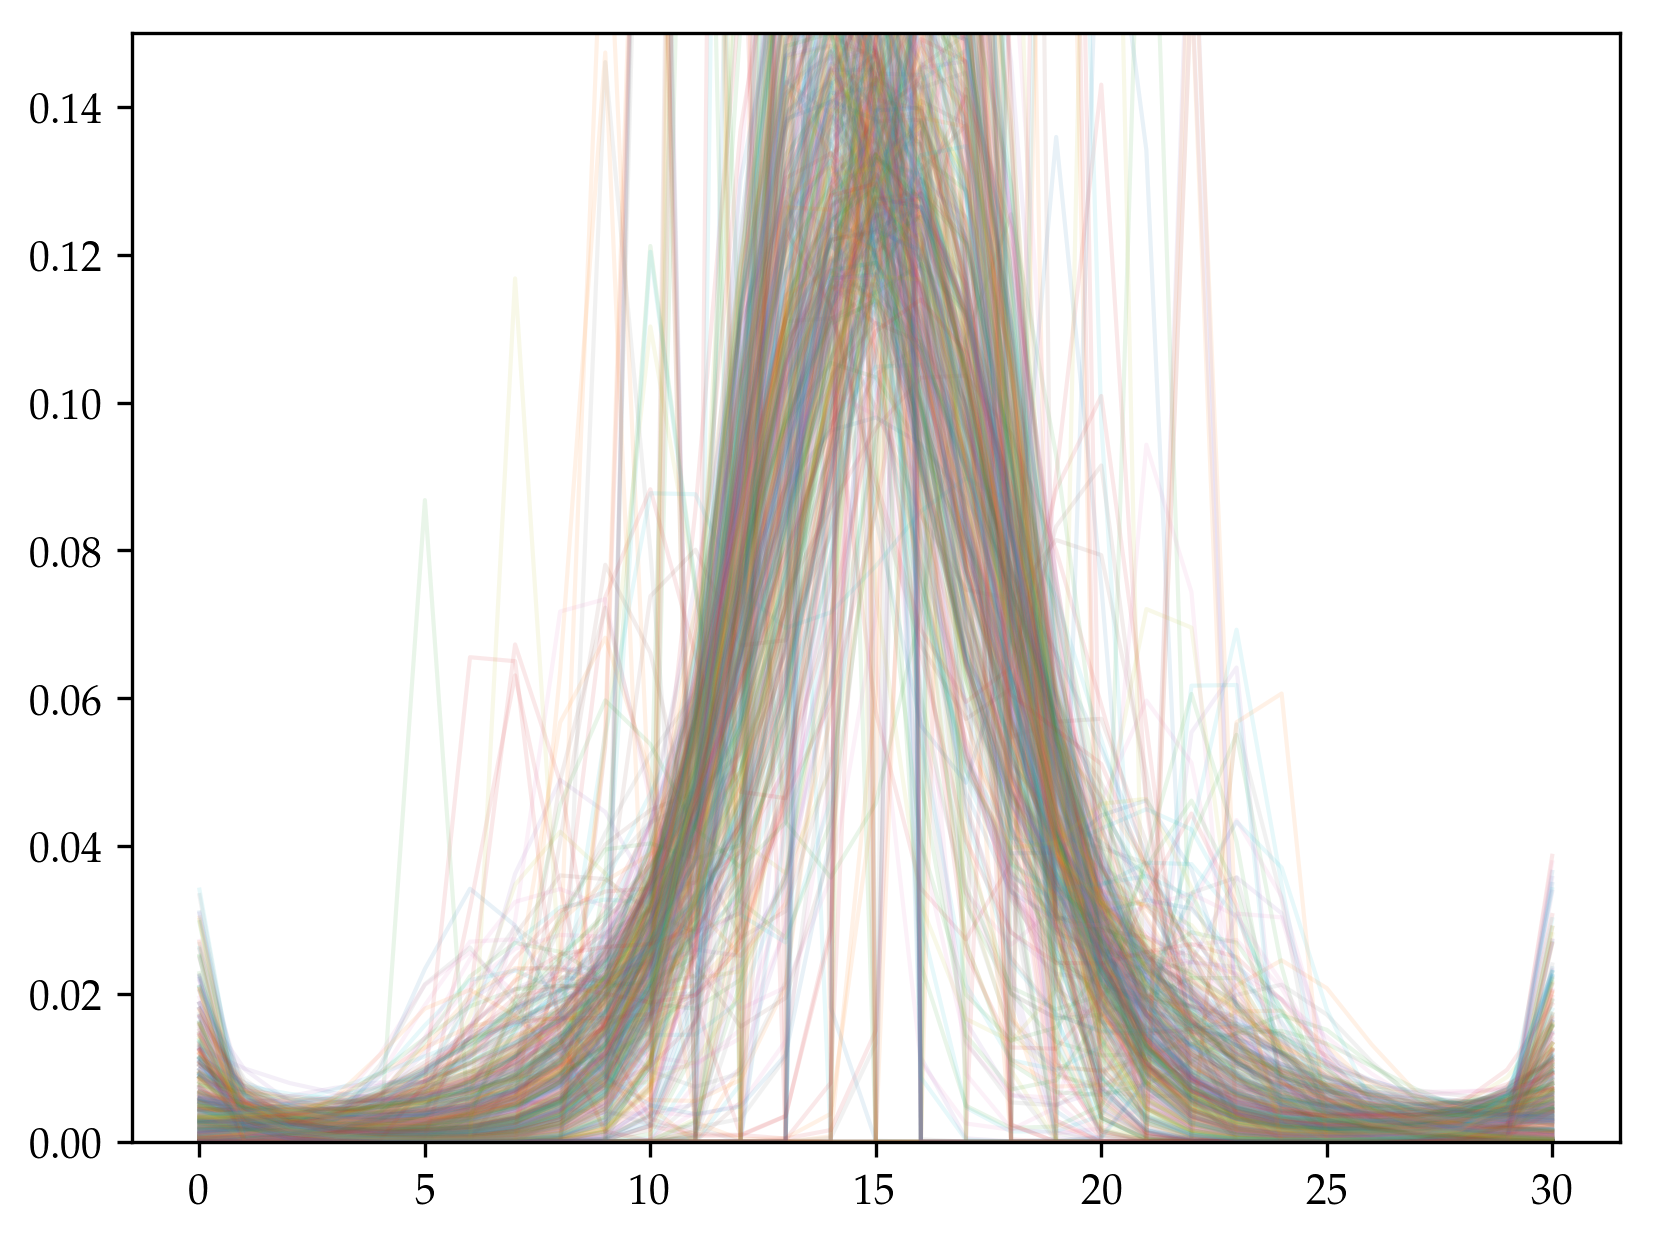

(0, 0.15)

In [117]:
for b in 1:500
    plt.plot(ghat_b[b, :], alpha=0.1, linewidth=1)
end
plt.ylim(0, 0.15)

# Regularization

In [118]:
c0 = 2
f = ExpoFamSpline.make_penalized_w_noise_pre(d, example_noise, X_sim, c0)
td = TwiceDifferentiable(f, copy(coefs(d)); autodiff=:forward)
opt_reg = optimize(td, zero(coefs(d)), Optim.Newton())
@time opt_reg = optimize(td, zero(coefs(d)), Optim.Newton())

  0.124297 seconds (53.84 k allocations: 160.912 MiB, 16.13% gc time)


Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [0.0,0.0,0.0,0.0,0.0]
 * Minimizer: [3.376612431922466,3.355862762311414, ...]
 * Minimum: 1.634312e+03
 * Iterations: 11
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 7.91e-06 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 3.58e-14 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.77e-11 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 84
 * Gradient Calls: 84
 * Hessian Calls: 22

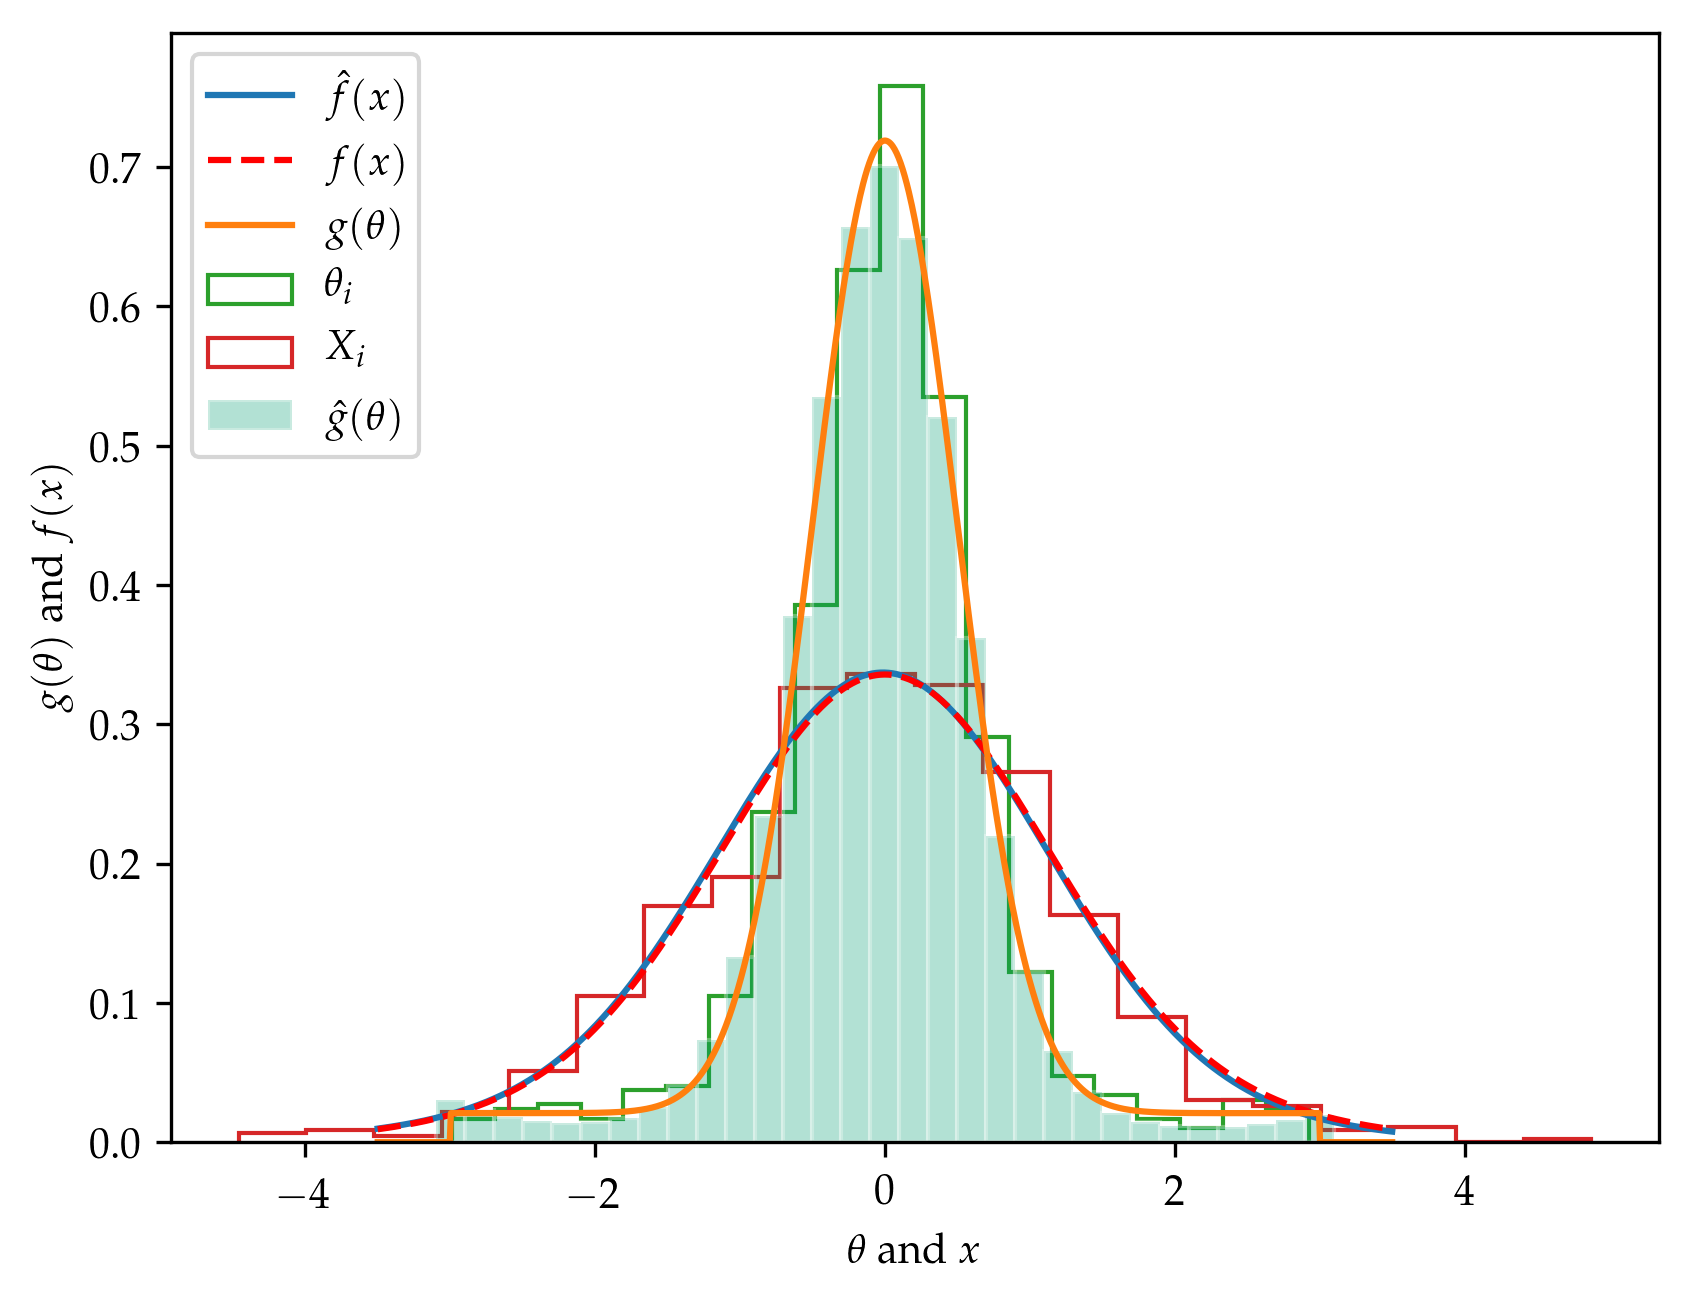

In [119]:
d_optim = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, Optim.minimizer(opt_reg))

f_x_unnormalised = exp.([convolved_log_fx(d_optim, d_optim.domain, example_noise, x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"\hat{f}(x)")

f_x_unnormalised = exp.([convolved_log_fx(example_gθ, range(-3.0, stop=3.0, length=51), example_noise, x) for x in xx])
f_x_normalised = f_x_unnormalised ./ sum(StatsBase.midpoints(f_x_unnormalised) .* diff(xx))
plt.plot(xx, f_x_normalised, label=L"f(x)", color="red", linestyle="--")

plt.plot(xx, pdf.(example_gθ, xx), label=L"g(\theta)")
plt.plt[:hist](θ_sim, histtype="step", normed=true, label=L"\theta_i", bins=20)
plt.plt[:hist](X_sim, histtype="step", normed=true, label=L"X_i", bins=20)
_ylim = plt.ylim()
plot_pdf(d_optim, label=L"\hat{g}(\theta)"; facecolor=cbbPalette[3], alpha=0.3, edgecolor="white")
plt.ylim(_ylim)
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.legend(loc="upper left")
;

# Repeat regularized

In [122]:
@time α_reg_500 = [repeat_efron_example(; regularized=true) for _ in 1:500];

 79.540913 seconds (35.04 M allocations: 89.550 GiB, 15.92% gc time)


In [123]:
ghat_b = Matrix{Float64}(undef, 500, length(d.domain))
for b in 1:500
    α_hat = α_reg_500[b]
    d_hat = ExpoFamSpline.ExpoSpline(d.domain, d.Qbasis, α_hat)
    ghat = pdf(d_hat)
    ghat_b[b,:] = ghat
end

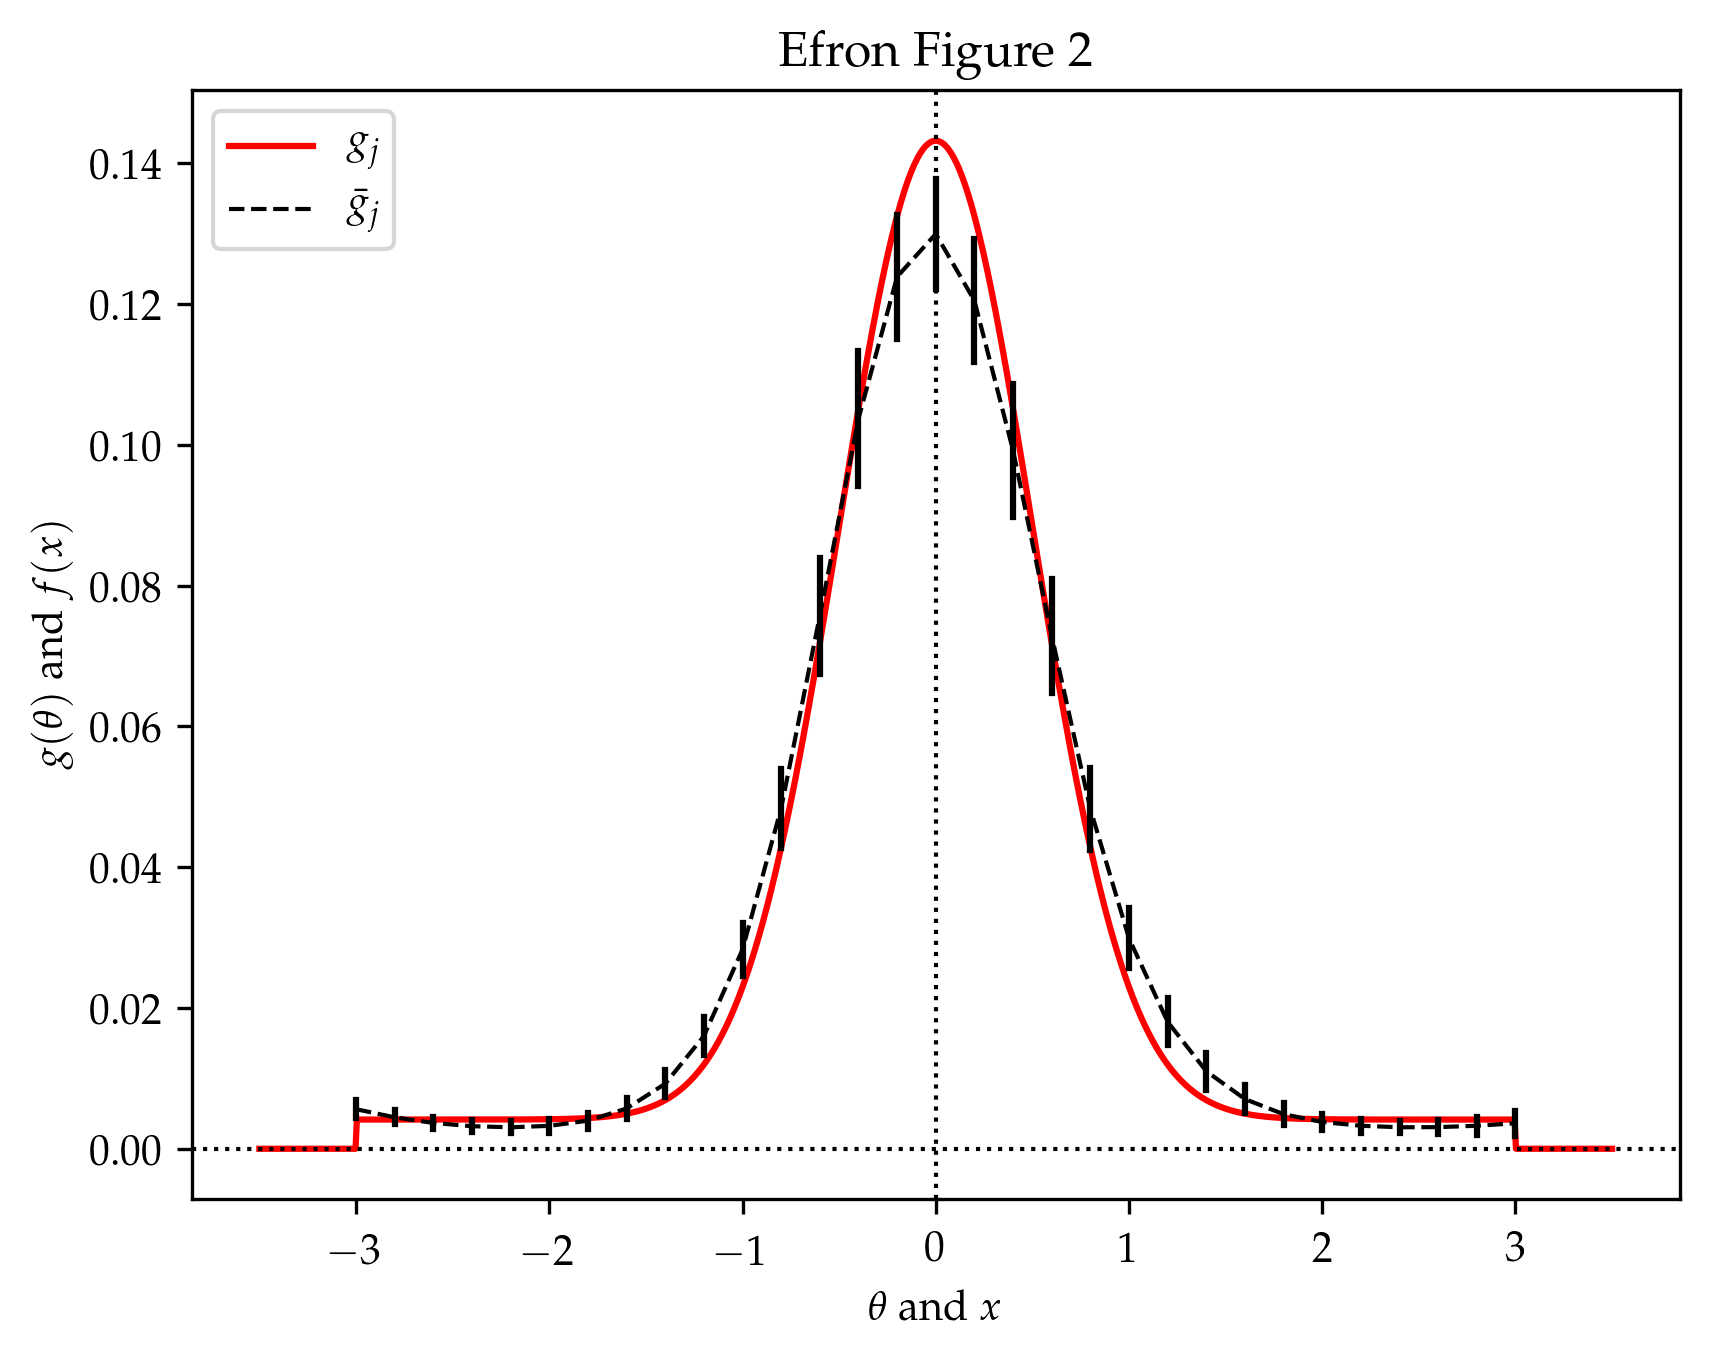

In [125]:
gbar = vec(mean(ghat_b, dims=1))
gstd = vec(std(ghat_b, dims=1))
g_true = pdf.(example_gθ, xx) ./ sum(pdf.(example_gθ, d.domain))
plt.plot(xx, g_true, label=L"g_j", color="red")
plt.plot(d.domain, gbar, label=L"\bar{g}_j", color="black", linewidth=1, linestyle="--")
for j in 1:length(d.domain)
    plt.plot([d.domain[j], d.domain[j]], [gbar[j]-gstd[j], gbar[j]+gstd[j]], "-", color="black")
end
plt.axvline(0.0, linestyle=":", color="black", linewidth=1)
plt.axhline(0.0, linestyle=":", color="black", linewidth=1)
# plt.fill_between(d.domain, gbar .- gstd, gbar .+ gstd)
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.legend(loc="upper left")
plt.title("Efron Figure 2")
;

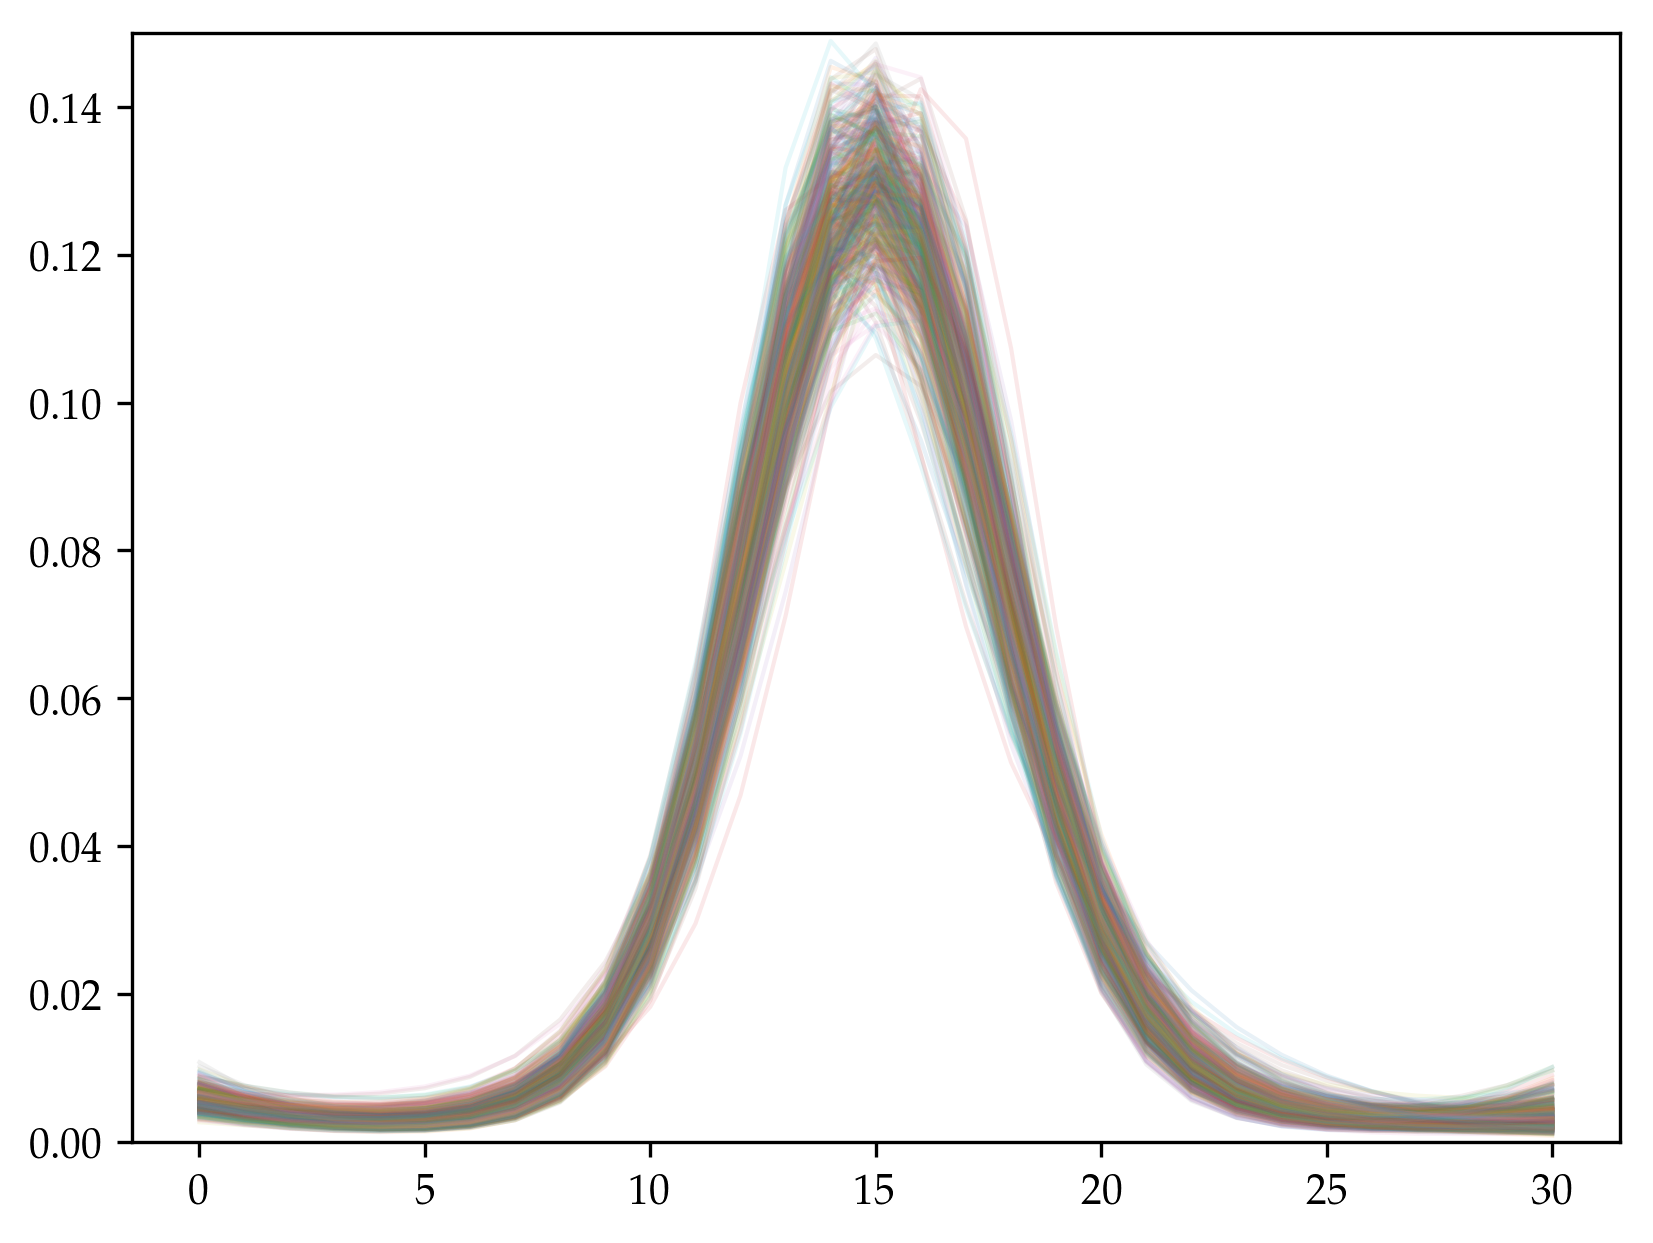

(0, 0.15)

In [126]:
for b in 1:500
    plt.plot(ghat_b[b, :], alpha=0.1, linewidth=1)
end
plt.ylim(0, 0.15)